# Analysing the network

The following code is made to analyse the network and properties of the data. The network can be made in two ways:
- Combined,
- Questions and answers seperate. In this network the questions and answers are

The following code is inspired by the research article "Look who’s talking: Two-mode networks as representations of a topic model of New Zealand parliamentary speeches" [1]. I have written all code myself and done much work to adapt the network solutions to fit our problem, but was helped by solutions from the article and the open source code it provided.

[1] Curran B, Higham K, Ortiz E, Vasques Filho D (2018) Look who’s talking: Two-mode networks as representations of a topic model of New Zealand parliamentary speeches. PLoS ONE 13(6): e0199072. https://doi.org/10.1371/journal.pone.0199072

Made by: Elsa Kidman

## How to run

required packages are:
- numpy
- pandas
- networkx
- matplotlib
- seaborn

In [2]:
import textwrap
import numpy as np
import pandas as pd
from datetime import datetime
from networkx.algorithms import bipartite
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Import the file of all data from 2006-2022 with topics
f = open('../../data/data_all/data_all_topic_final.json')
data_init = json.load(f)

# Create a dataframe of the data and then preform some preprocessing to the data
df = pd.DataFrame(data_init)

# Convert the date column to date format
df['question_date'] = pd.to_datetime(df['question_date'])

# Remove entries in regering that are of none type
df['regering'] = df['regering'].fillna(0).astype(int)
df = df[df['regering'] != 0] # Remove bad entries
df = df.reset_index(drop=True)

# Make sure to replace empty lists of answers with empty strings instead
def replace_empty_answers(lst):
    return '' if len(lst) == 0 else lst

df['top_10_words_answer'] = df['top_10_words_answer'].apply(replace_empty_answers)

# Display the dataframe
df.head()

id_                                           question question_date  \
0  gx11839  \nden \r\n27 maj\nFråga \n2009/10:839 \r\nÖkat...    2010-05-27   
1  gx11838  \nden \r\n26 maj\nFråga \n2009/10:838 \r\nFrys...    2010-05-26   
2  gx11837  \nden \r\n25 maj\nFråga \n2009/10:837 \r\nSver...    2010-05-25   
3  gx11836  \nden \r\n25 maj\nFråga \n2009/10:836 \r\nSJ o...    2010-05-25   
4  gx11835  \nden \r\n24 maj\nFråga \n2009/10:835 \r\nAvrä...    2010-05-24   

                                              answer    undertecknare_name  \
0  \nden 2 juni\nSvar på fråga\n2009/10:839 Ökat ...  Karin Svensson Smith   
1  \nden \r\n3 juni\nSvar på fråga\n2009/10:838 F...     Birgitta Eriksson   
2  \nden 4 juni\nSvar på fråga\n2009/10:837 Sveri...          Ameer Sachet   
3  \nden 1 juni\nSvar på fråga\n2009/10:836 SJ oc...          Ameer Sachet   
4  \nden 10 juni\nSvar på fråga\n2009/10:835 Avrä...      Helena Bargholtz   

  undertecknare_partibet  besvaradav_name besvaradav_partibet  regering  \
0                     MP  Åsa Torstensson                   C        48   
1                      S     Beatrice Ask                   M        48   
2                      S     Ewa Björling                   M        48   
3                      S    Maud Olofsson                   C        48   
4                     FP       Carl Bildt                   M        48   

   id_topic_combined                              top_10_words_combined  \
0                 72  cykling, motorcyklister, cyklister, elsparkcyk...   
1                  4  bankerna, finansiella, banker, finansinspektio...   
2                194  epa, ceta, förhandlingarna, avs, avtalet, avs ...   
3                  0  trafikverket, sj, eneroth, tomas eneroth, toma...   
4                 17  iran, iranska, mänskliga, rättigheter, mänskli...   

   id_topic_question                              top_10_words_question  \
0                155  cykling, elsparkcyklar, cyklister, cykla, omkö...   
1                 94  tullverket, brottslighet, stöldgods, brottsnät...   
2                148  ceta, epa, förhandlingarna, avs, handelsavtal,...   
3                 81  tågtrafiken, trafikverket, tåg, elmsäter, cath...   
4                 20  iran, iranska, mänskliga, irans, rättigheter, ...   

  id_topic_answer                                top_10_words_answer  
0             155  cykling, elsparkcyklar, cyklister, cykla, omkö...  
1              94  tullverket, brottslighet, stöldgods, brottsnät...  
2               4  etiopien, västsahara, somaliland, somalia, fn,...  
3             282  sj, sj ab, ab, tåg, resenärer, tågtrafik, bilj...  
4              20  iran, iranska, mänskliga, irans, rättigheter, ...

In [3]:
for i in range(1,6):
  o = df[(df['id_topic_question']==i)]['top_10_words_question']
  print(o.values[1])

migrationsverket, asylsökande, uppehållstillstånd, afghanistan, migrationsverkets, morgan johansson, morgan, justitie, migrationsminister, migrationsminister morgan
finansminister, skatteverket, anders borg, borg, finansminister anders, finansministern, magdalena andersson, magdalena, andersson, anders
bostäder, bostadsmarknaden, hyresrätter, bostad, bostadsbyggandet, boverket, bostadsbyggande, odell, mats odell, statsrådet mats
etiopien, västsahara, somaliland, somalia, fn, marocko, humanitära, kongo, utrikesminister, utrikesminister carl
djur, hundar, veterinärer, jordbruksverket, djurskydd, djuren, eskil erlandsson, erlandsson, eskil, djurskyddet


### Creating the functions to make bipartite graphs

In [4]:
# A function to create a graph of the type 'combined topics'. This is when the topic is taken for both question and answer combined as one long entry.
# The graph is a bipartite (two-mode) graph
def create_graph_combined(data, directed=False):

  if directed == False:
    B = nx.Graph()
    for i, entry in data.iterrows():
      person_ask = entry['undertecknare_name']
      person_ask_party = entry['undertecknare_partibet']
      person_ans = entry['besvaradav_name']
      person_ans_party = entry['besvaradav_partibet']
      topic_combined = entry['top_10_words_combined']

      B.add_node(person_ask, party=person_ask_party, bipartite=0)
      B.add_node(person_ans, party=person_ans_party, bipartite=0)
      B.add_node(topic_combined, party="topic", bipartite=1)

      B.add_edge(person_ask,topic_combined)
      B.add_edge(topic_combined,person_ans)

  else: # If the graph is directed
    B = nx.DiGraph()
    for i, entry in data.iterrows():
      person_ask = entry['undertecknare_name']
      person_ask_party = entry['undertecknare_partibet']
      person_ans = entry['besvaradav_name']
      person_ans_party = entry['besvaradav_partibet']
      topic_combined = entry['top_10_words_combined']

      B.add_node(person_ask, party=person_ask_party, bipartite=0)
      B.add_node(person_ans, party=person_ans_party, bipartite=0)
      B.add_node(topic_combined, party="topic", bipartite=1)

      B.add_edge(person_ask,topic_combined)
      B.add_edge(topic_combined,person_ans)

  if bipartite.is_bipartite(B):
    return B
  else:
    print("not bipartite")
    return None

# Creates a bipartite (two-mode) graph of questions and answers seperatly, i.e as different nodes but same bipartite node type.
def create_graph_qa(data, directed=False):

  if directed == False:
    B = nx.Graph()
    for i, entry in data.iterrows():
      person_q = entry['undertecknare_name']
      person_q_party = entry['undertecknare_partibet']

      person_a = entry['besvaradav_name']
      person_a_party = entry['besvaradav_partibet']

      topic_q = entry['top_10_words_question']
      topic_a = entry['top_10_words_answer']

      B.add_node(person_q, party=person_q_party, bipartite=0)
      B.add_node(person_a, party=person_a_party, bipartite=0)

      B.add_node(topic_q, party="topic", bipartite=1)
      if len(topic_a) == 0:
        B.add_node("empty", party="topic", bipartite=1)
        B.add_edge("empty", person_a)
      else:
        B.add_node(topic_a, party="topic", bipartite=1)
        B.add_edge(topic_a, person_a)

      B.add_edge(person_q, topic_q)
  # If directed
  else:
    B = nx.DiGraph()
    for i, entry in data.iterrows():
      person_q = entry['undertecknare_name']
      person_q_party = entry['undertecknare_partibet']

      person_a = entry['besvaradav_name']
      person_a_party = entry['besvaradav_partibet']

      topic_q = entry['top_10_words_question']
      topic_a = entry['top_10_words_answer']

      B.add_node(person_q, party=person_q_party, bipartite=0)
      B.add_node(person_a, party=person_a_party, bipartite=0)

      B.add_node(topic_q, party="topic", bipartite=1)
      if len(topic_a) == 0:
        B.add_node("empty", party="topic", bipartite=1)
        B.add_edge("empty", person_a)
      else:
        B.add_node(topic_a, party="topic", bipartite=1)
        B.add_edge(topic_a, person_a)

      B.add_edge(person_q, topic_q)

  if bipartite.is_bipartite(B):
    return B
  else:
    print("not bipartite")
    return None

There are different ways to divide up all the data:
1. Years, the data is divided into the years when the question was asked.
2. Goverments, the data is divided into the different goverments (regering), which have a corresponding number and name. These are not always in four year periods, but can be shorter, like for example Löfven III
who ruled between 2021-07-10 and 2021-11-30.
3. Four year periods (elections), the data is divided into equaly sized four year periods which corresponds to the time betweeen each election.

In [5]:
# 1. Divide the data by year
grouped_by_year = df.groupby(df['question_date'].dt.year)
years = []
dfs_by_year = {}
data_years = []

for year, group_df in grouped_by_year:
  data_years.append(group_df)
  dfs_by_year[year] = group_df
  years.append(year)

# Create graphs by year
graphs_year_comb = []
graphs_year_comb_dir = []
graphs_year_qa = []
graphs_year_qa_dir = []

for data in data_years:
  # Combined
  graph_comb = create_graph_combined(data)
  graphs_year_comb.append(graph_comb)
  graph_comb_dir = create_graph_combined(data, directed=True)
  graphs_year_comb_dir.append(graph_comb_dir)
  # Questions and answers
  graph_qa = create_graph_qa(data)
  graphs_year_qa.append(graph_qa)
  graph_qa_dir = create_graph_qa(data, directed=True)
  graphs_year_qa_dir.append(graph_qa_dir)


# 2. Dividing the data and graphs by goverement
goverments = df['regering'].unique()
goverments = np.sort(goverments)

# Divide the data by ruling parties
data_gov = []
for i in goverments:
  tmp = df[(df['regering'] == i)]
  tmp = tmp.reset_index(drop=True)
  data_gov.append(tmp)

# Create graphs with data in the goverment periods
graphs_gov_comb = []
graphs_gov_comb_dir = []
graphs_gov_qa = []
graphs_gov_qa_dir = []

for data in data_gov:
  # Combined
  graph_comb = create_graph_combined(data)
  graphs_gov_comb.append(graph_comb)
  graph_comb_dir = create_graph_combined(data, directed=True)
  graphs_gov_comb_dir.append(graph_comb_dir)

  # Questions and Answers
  graph_qa = create_graph_qa(data)
  graphs_gov_qa.append(graph_qa)
  graph_qa_dir = create_graph_qa(data, directed=True)
  graphs_gov_qa_dir.append(graph_qa_dir)

# 3. Divide by elections
election_interval = [ ["2006-09-18","2010-09-19"],
                    ["2010-09-20","2014-09-14"],
                    ["2014-09-15","2018-09-09"],
                    ["2018-09-10","2022-10-18"] ]

data_elections = []
for election_period in election_interval:
  start = pd.to_datetime(election_period[0])
  end = pd.to_datetime(election_period[1])
  result = df[(start <= df['question_date']) & (df['question_date'] <= end)]
  result = result.sort_values(by='question_date', ascending=True).reset_index(drop=True)
  data_elections.append(result)

# Create graphs with data in the four year election periods
graphs_e_comb = []
graphs_e_comb_dir = []
graphs_e_qa = []
graphs_e_qa_dir = []

for data in data_elections:
  # Combined
  graph_e = create_graph_combined(data)
  graphs_e_comb.append(graph_e)
  graph_e_dir = create_graph_combined(data, directed=True)
  graphs_e_comb_dir.append(graph_e_dir)

  # Questions and Answers
  graph_e_qa = create_graph_qa(data)
  graphs_e_qa.append(graph_e_qa)
  graph_e_qa_dir = create_graph_qa(data, directed=True)
  graphs_e_qa_dir.append(graph_e_qa_dir)

## Disconected graph
For the seperate questions and answers some graphs are disconnected. The disconected graphs can be seen below. It can be seen that it alwas exist one larger connected graph and some smaller that only contains two nodes (one person and one topic).

7


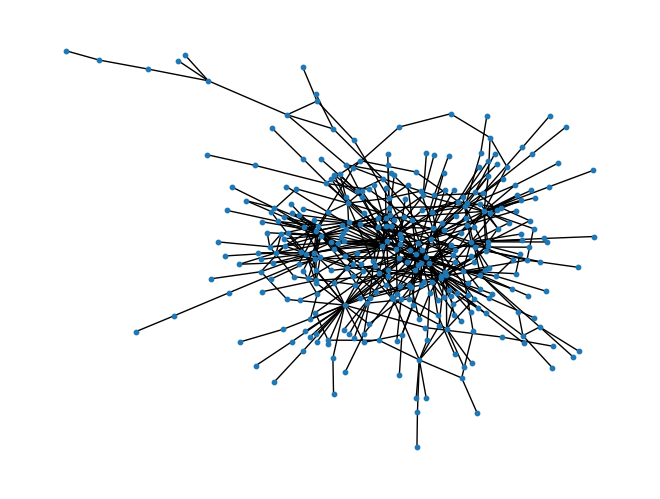

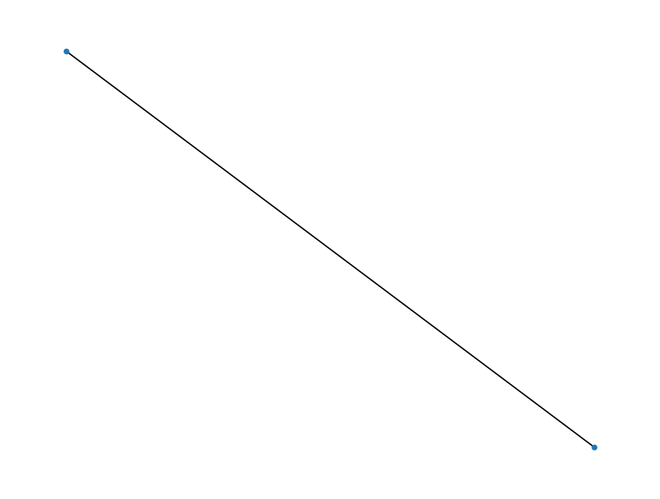

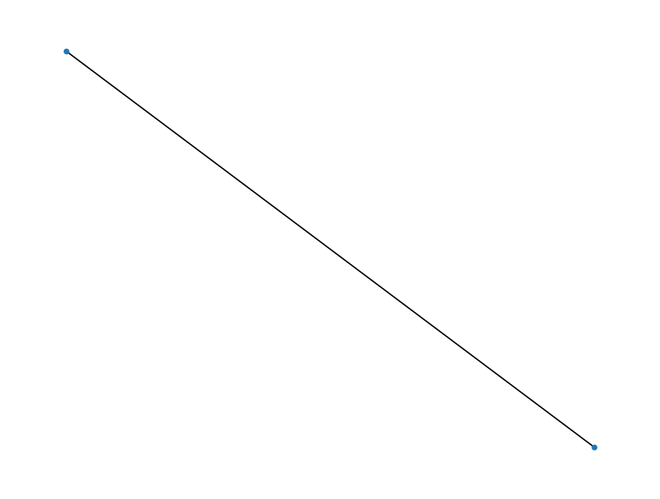

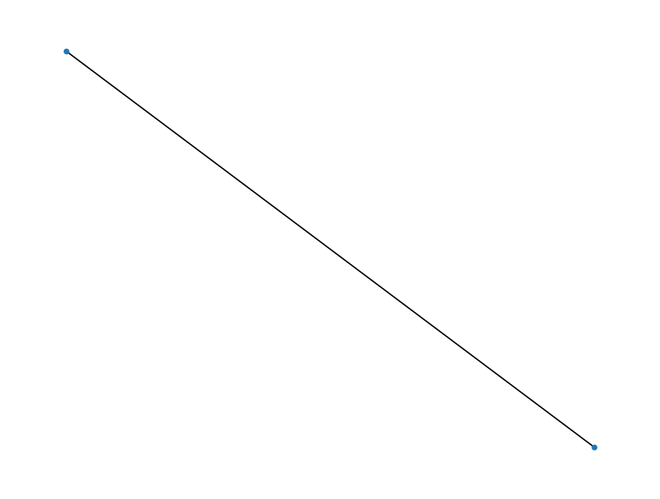

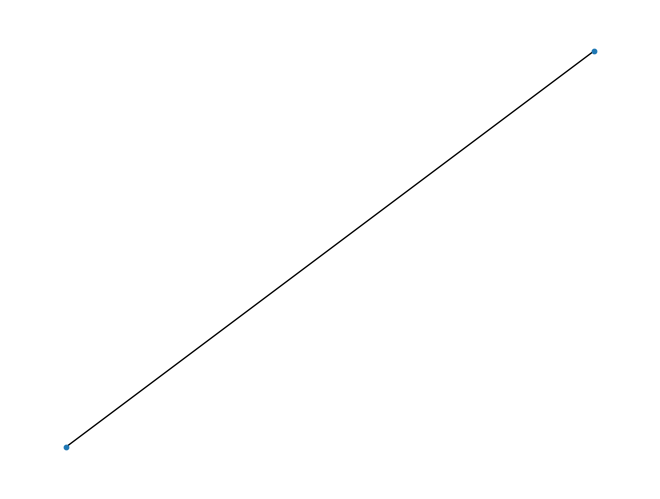

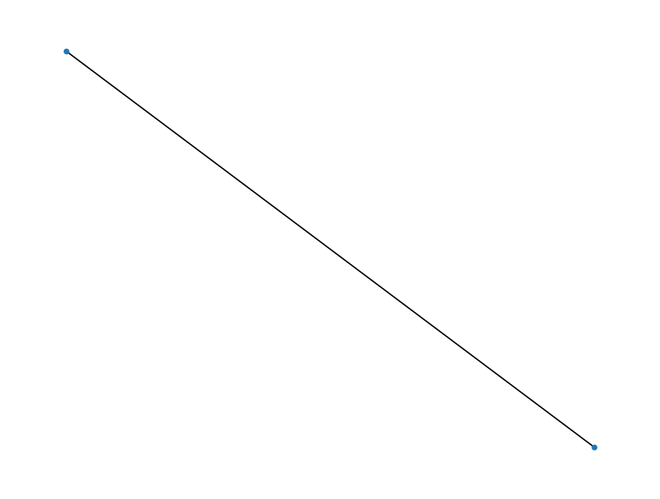

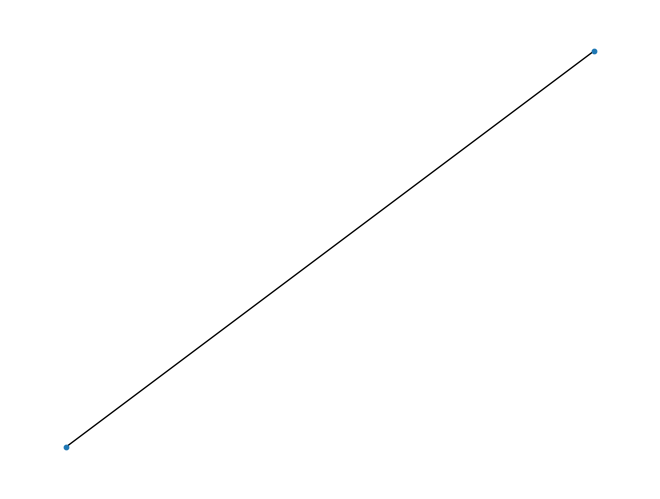

4


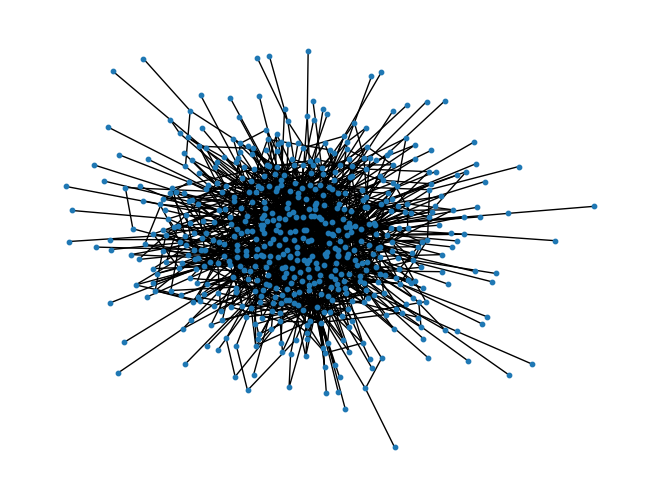

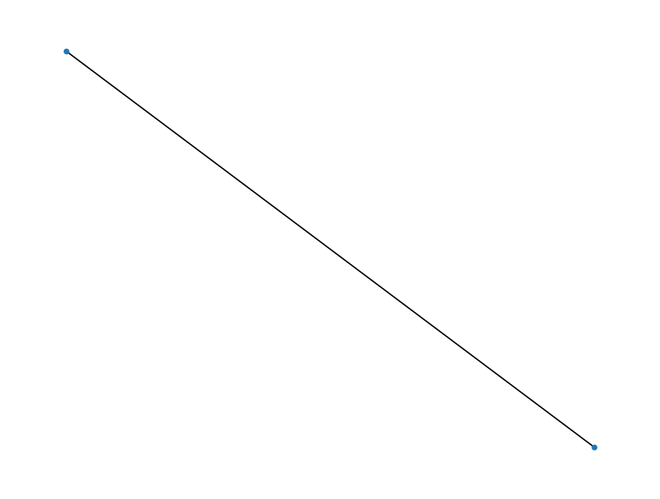

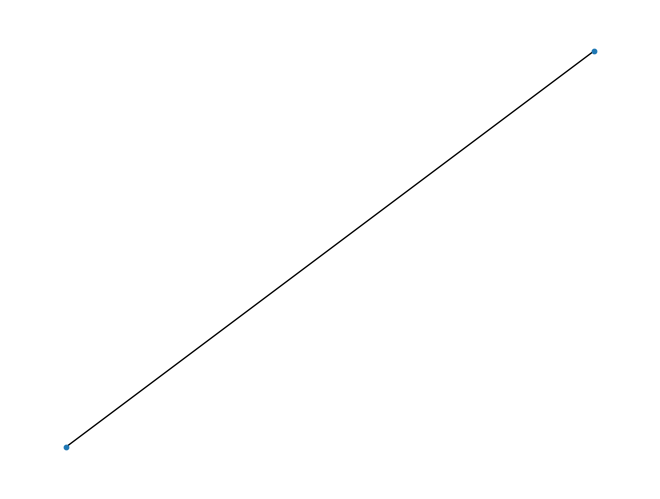

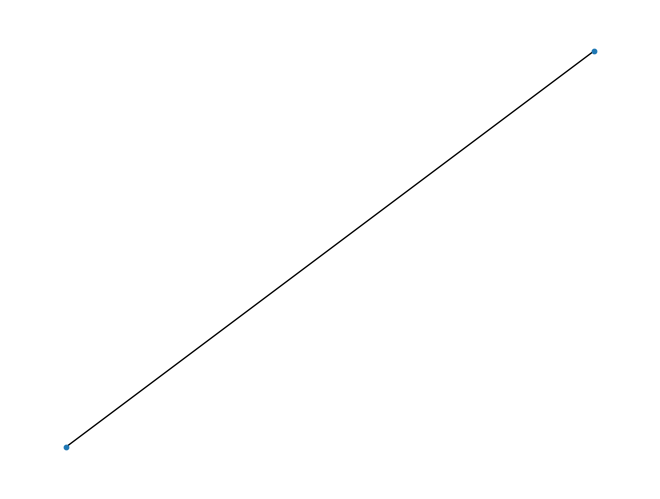

5


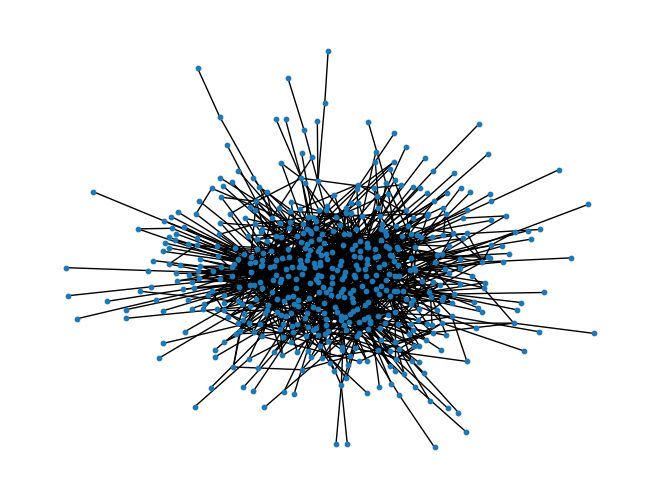

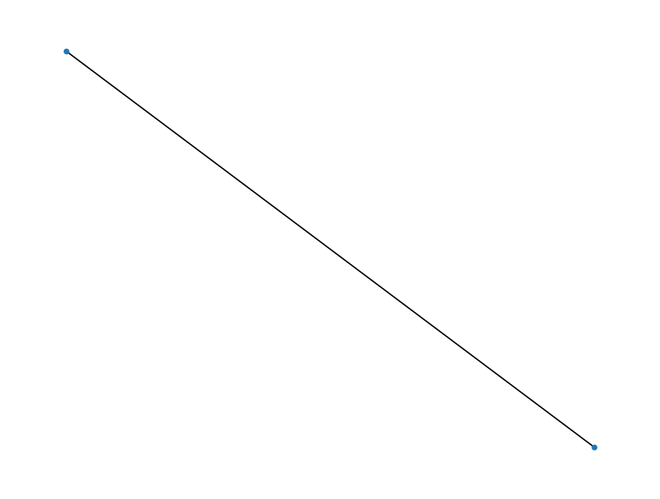

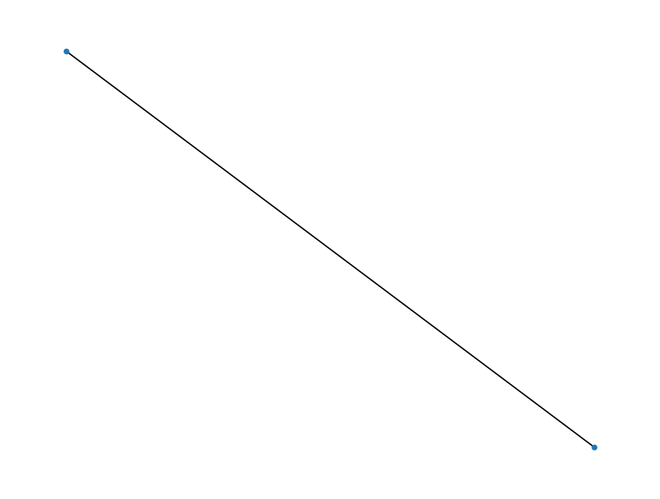

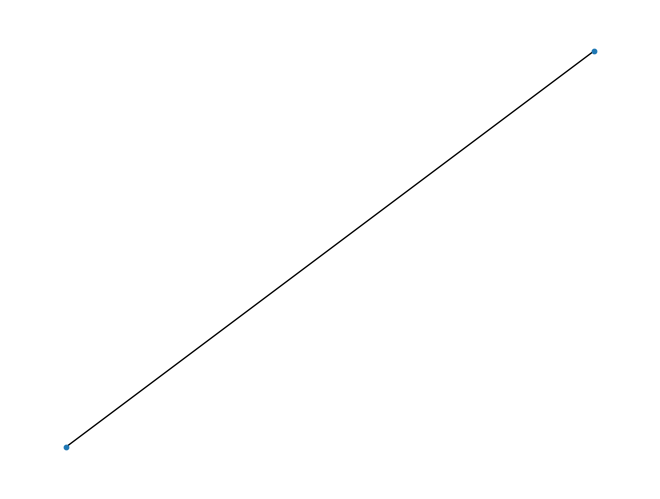

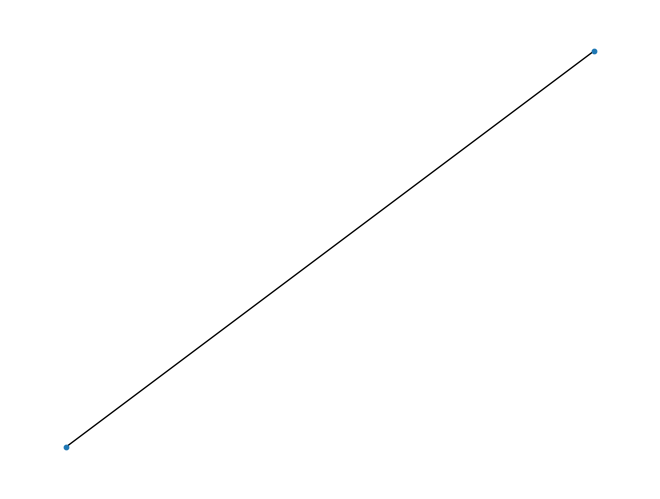

5


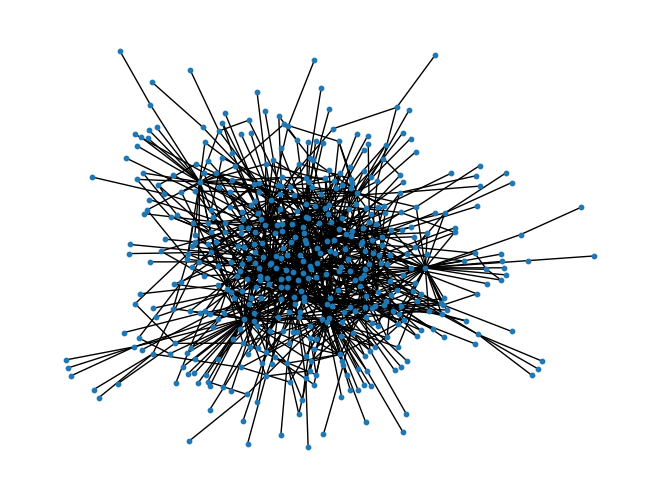

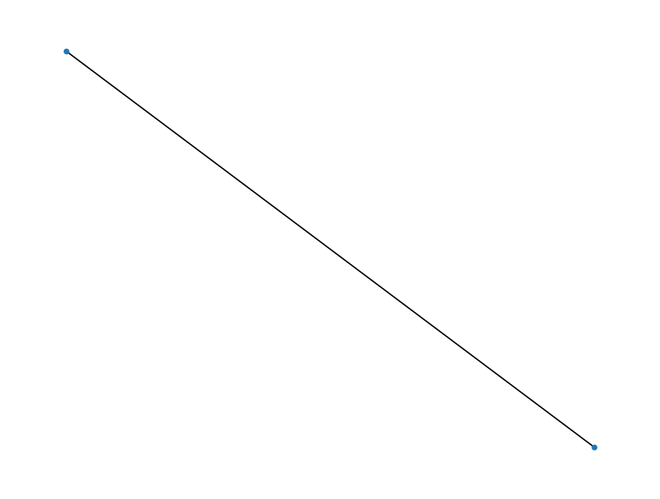

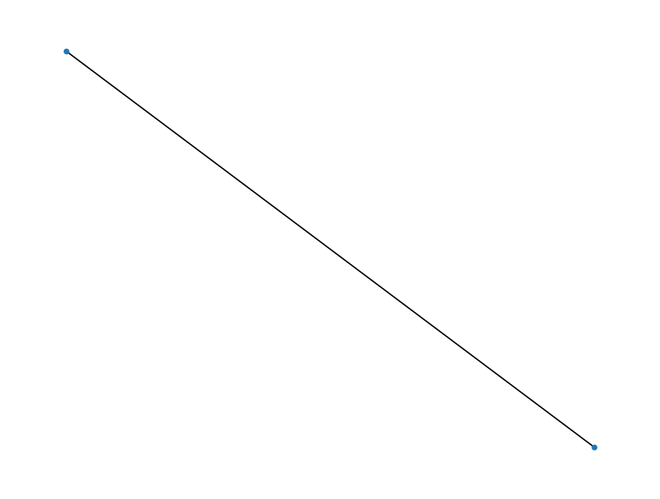

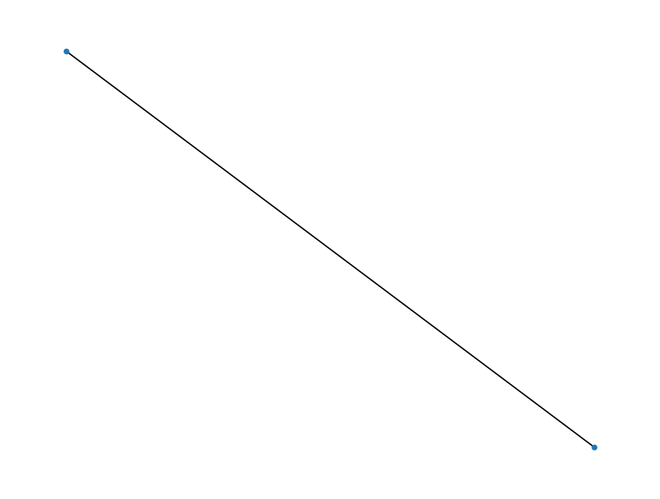

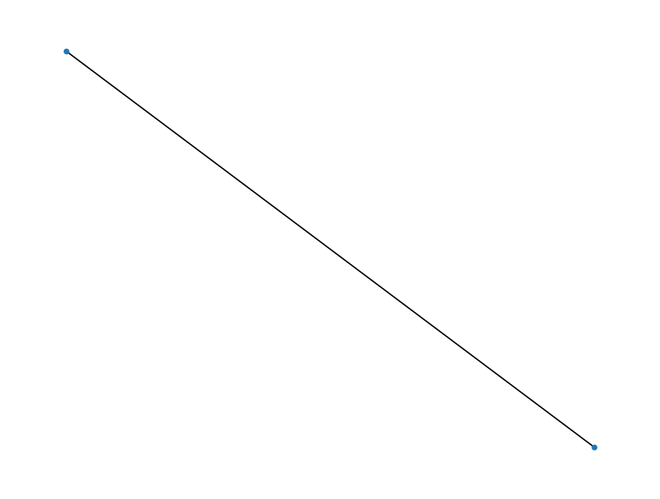

7


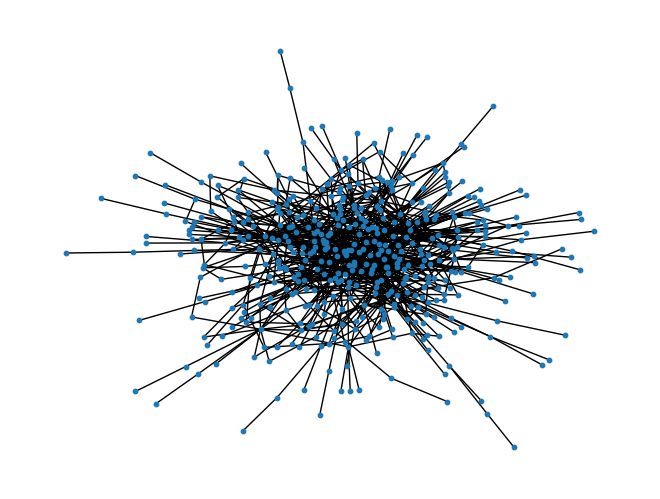

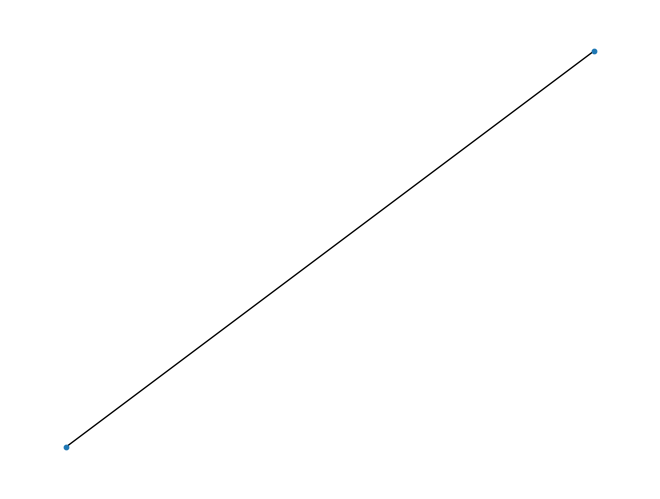

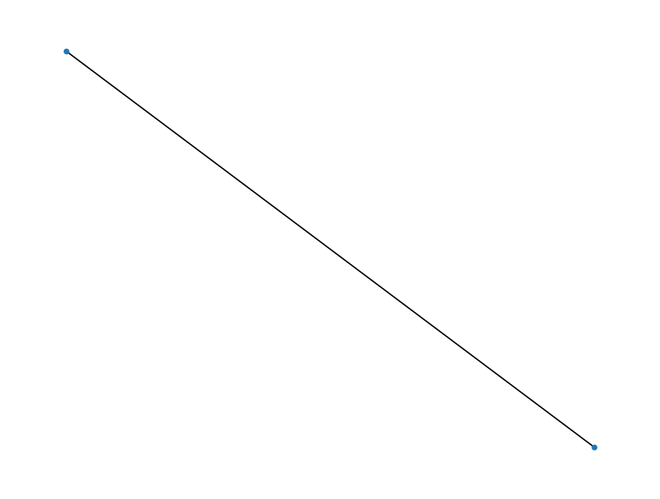

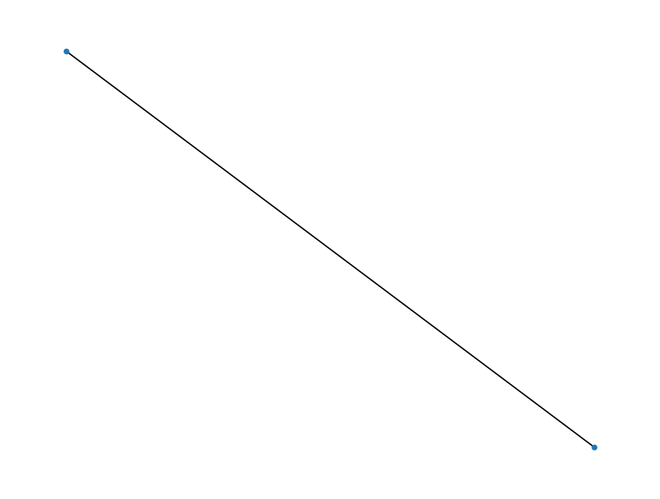

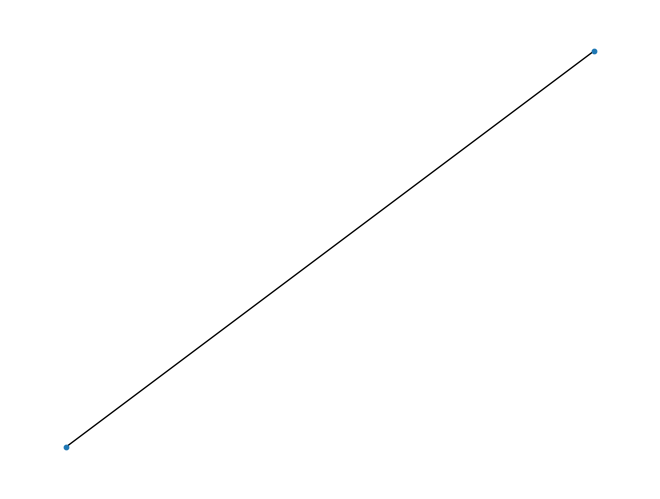

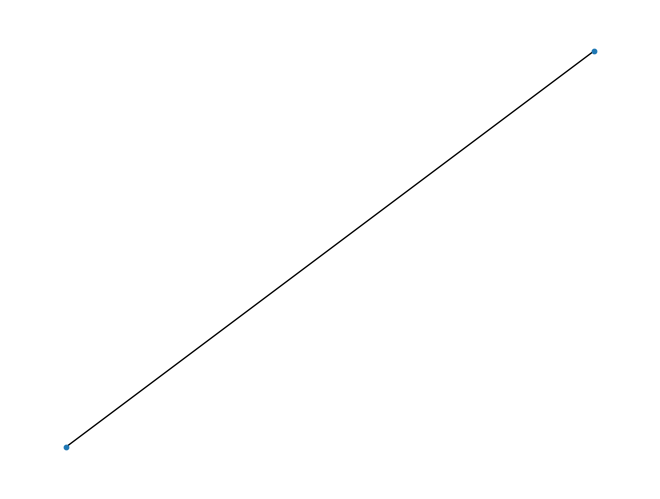

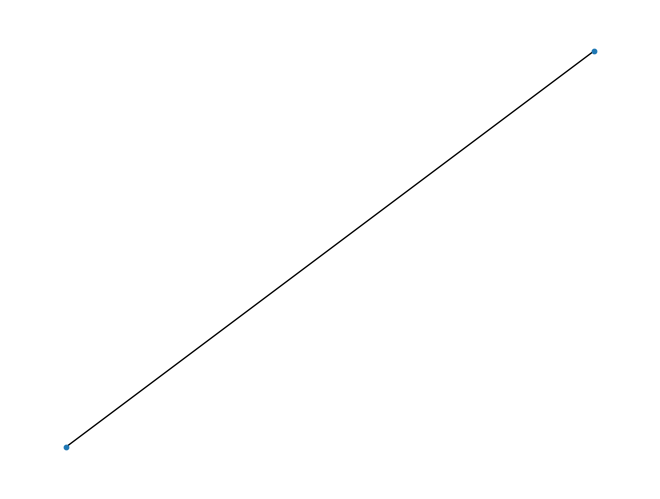

4


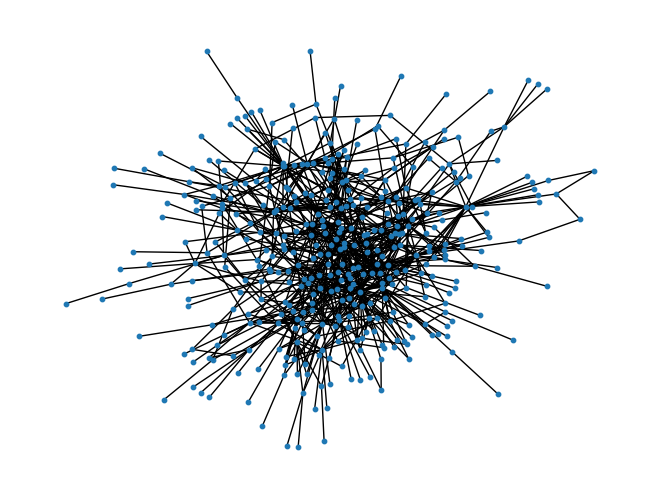

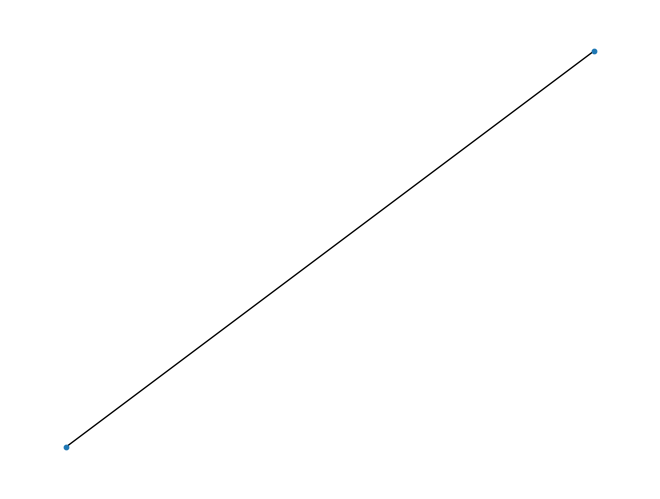

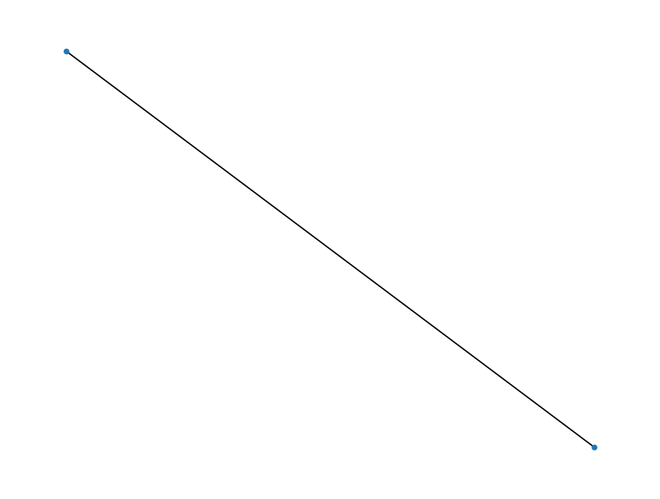

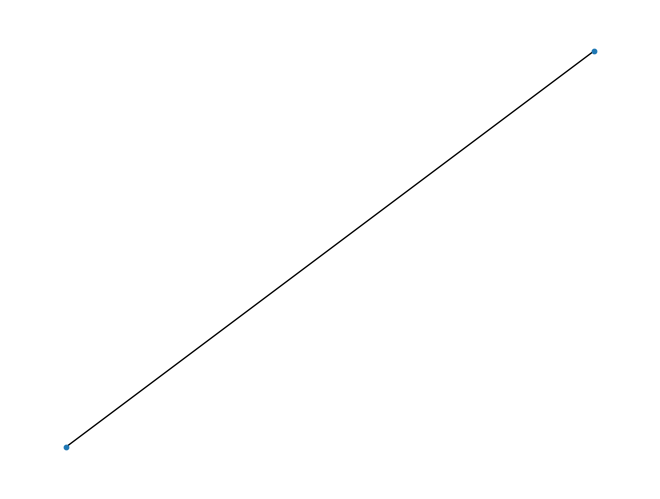

4


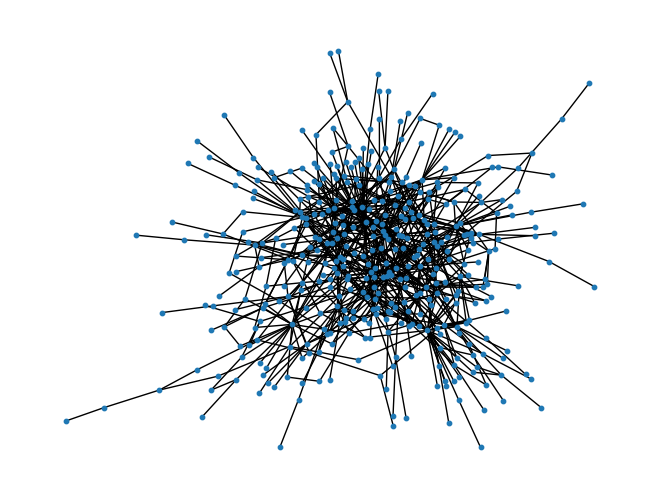

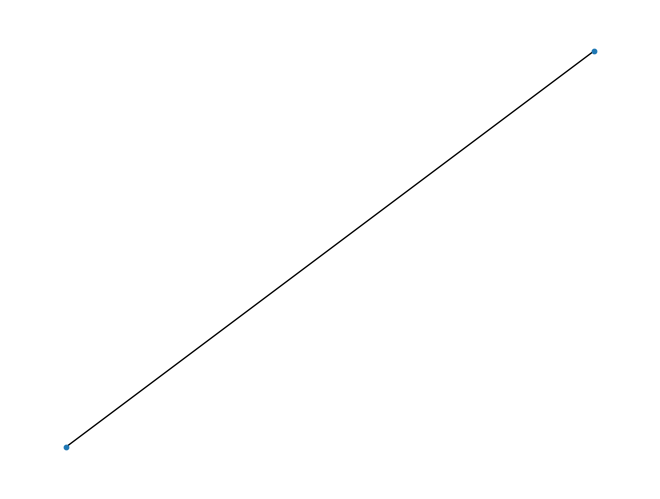

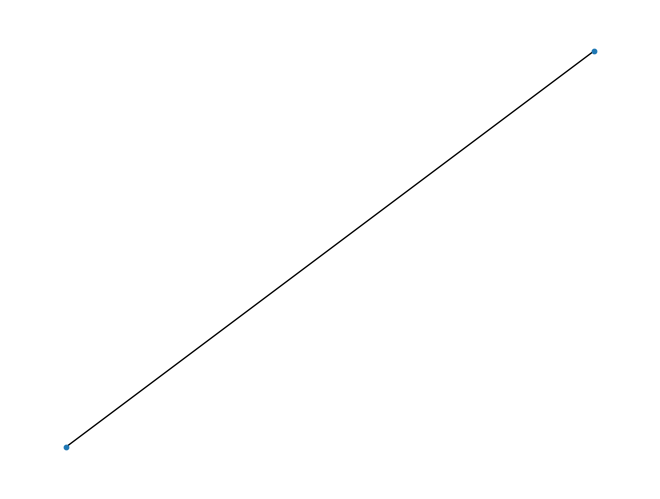

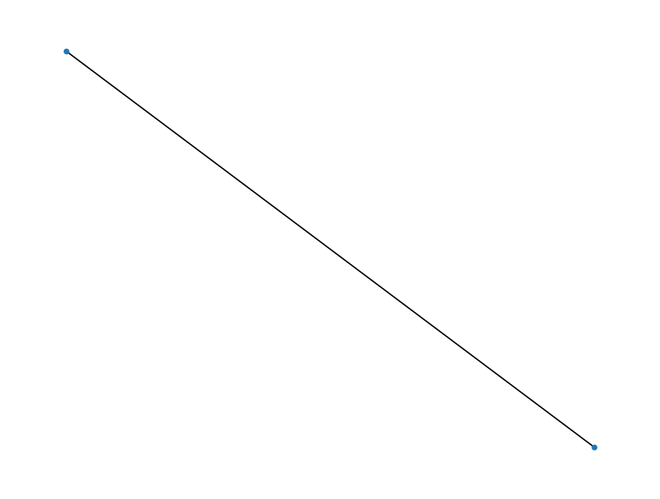

4


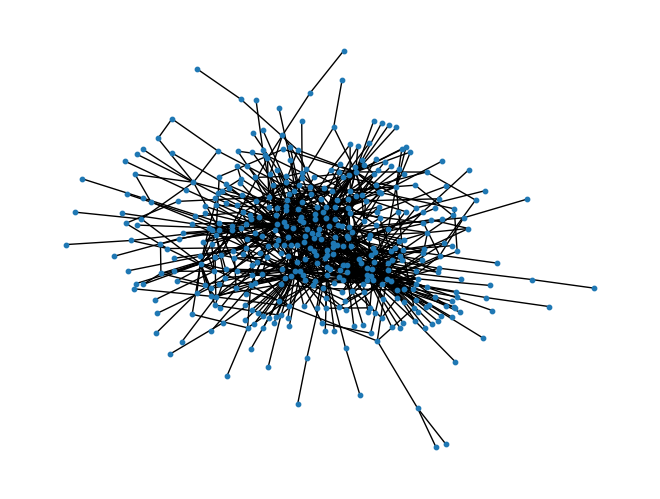

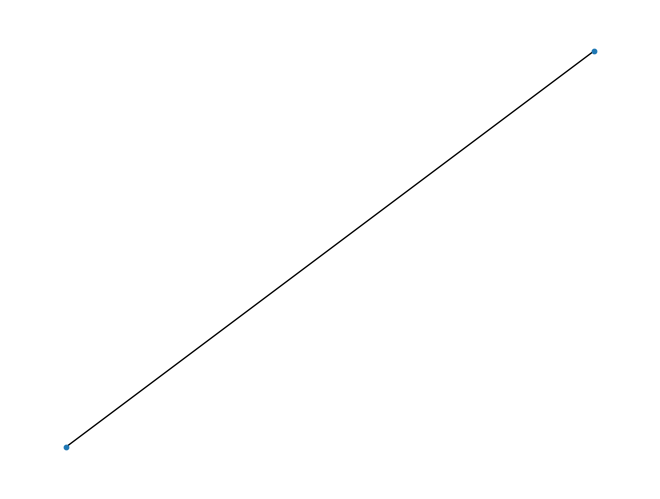

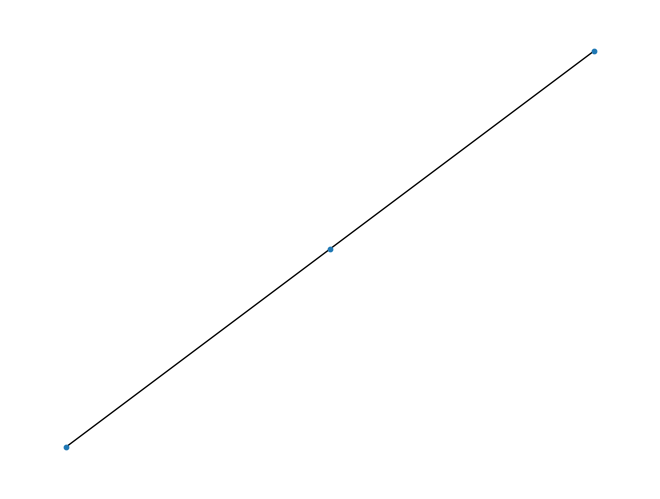

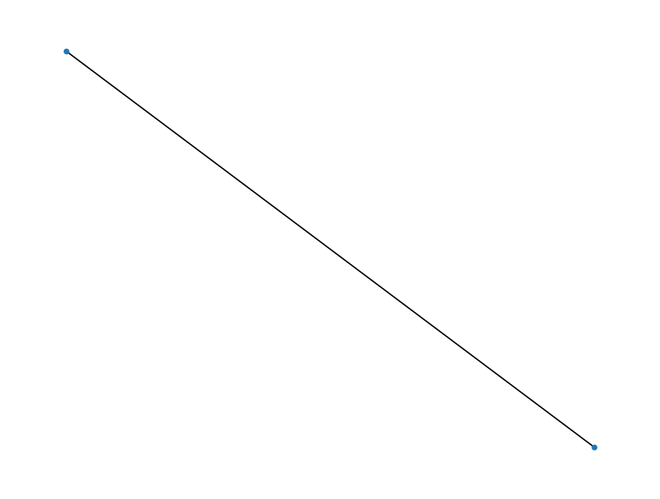

8


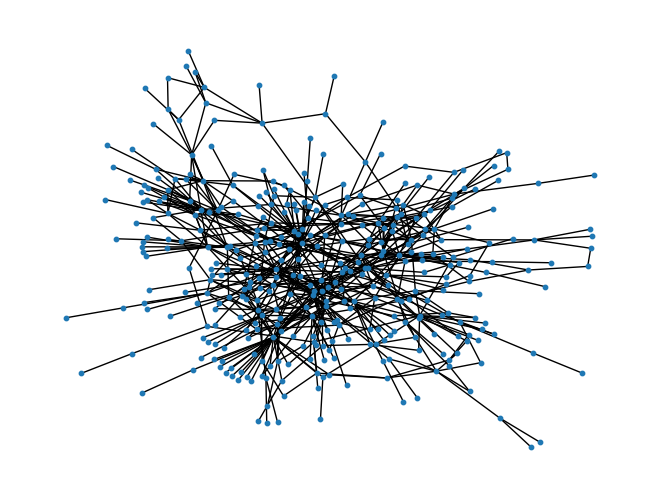

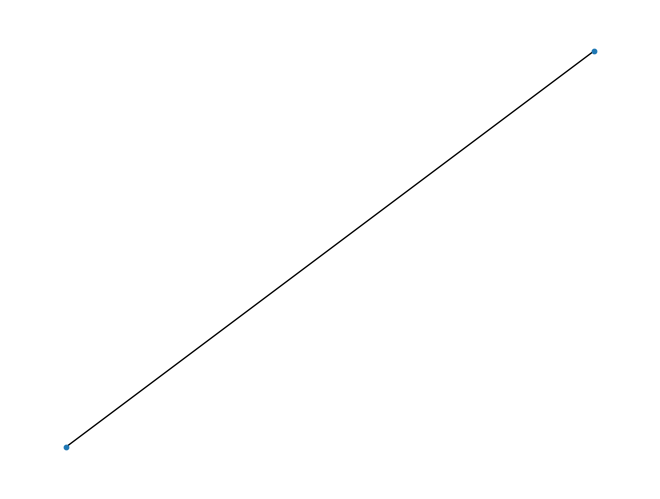

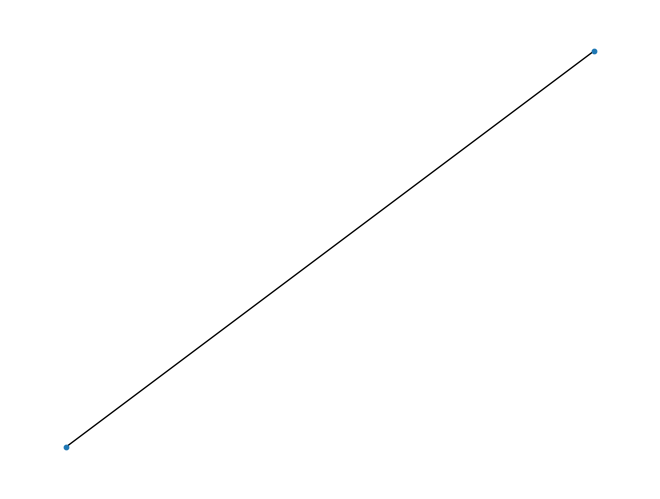

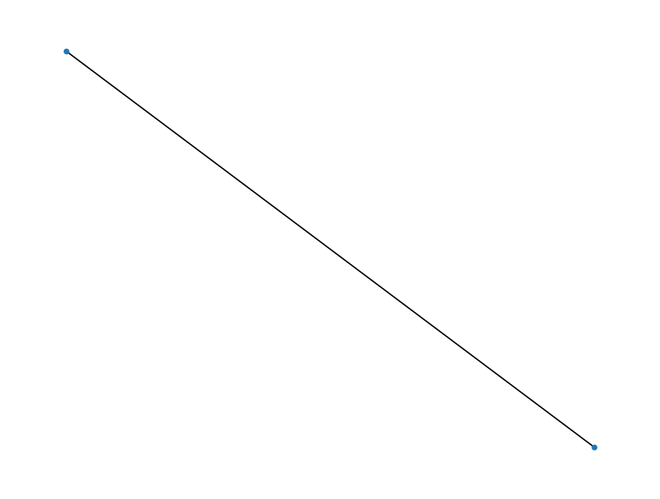

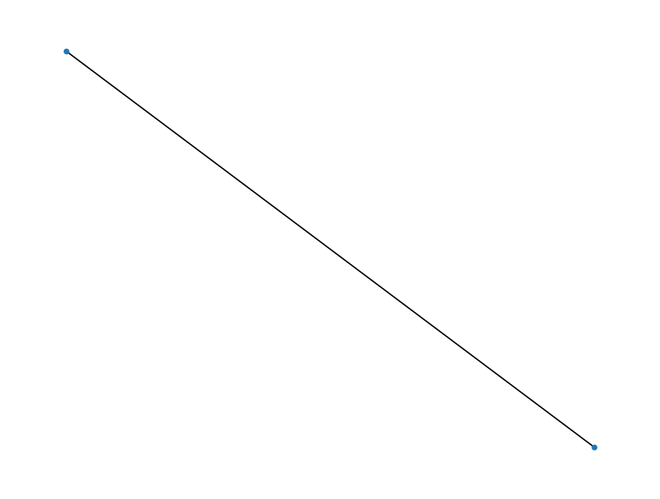

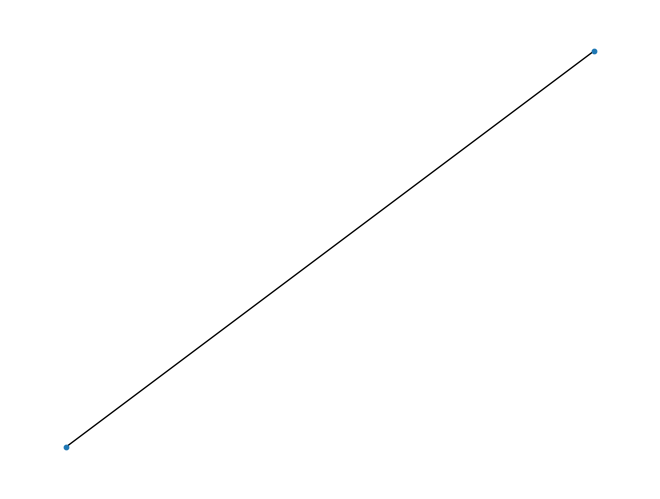

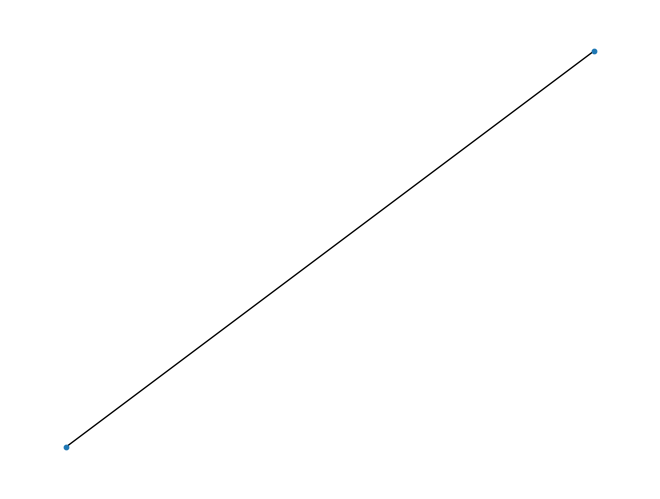

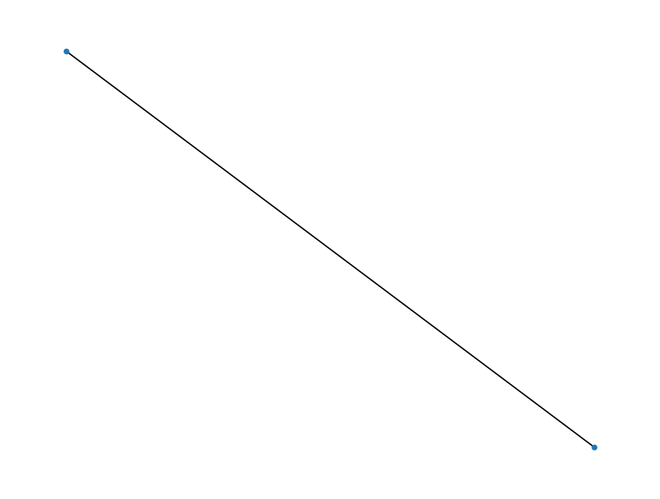

3


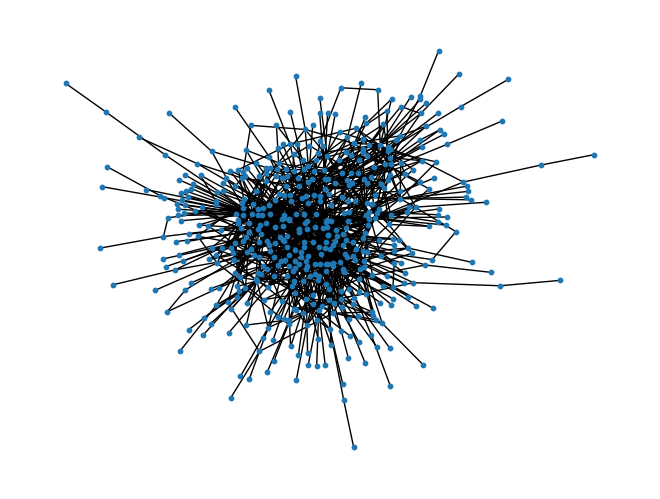

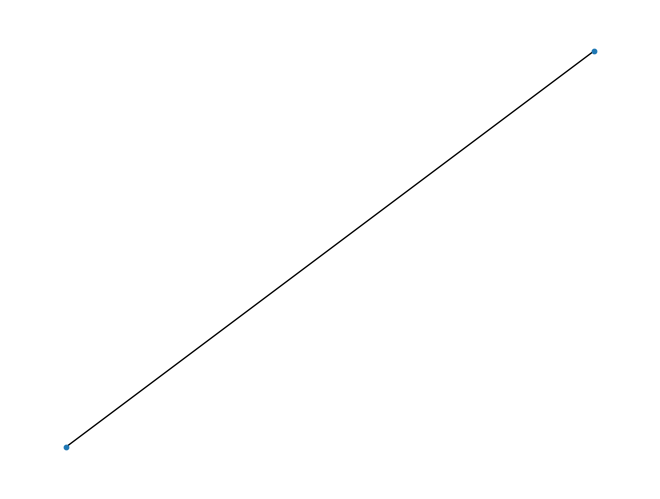

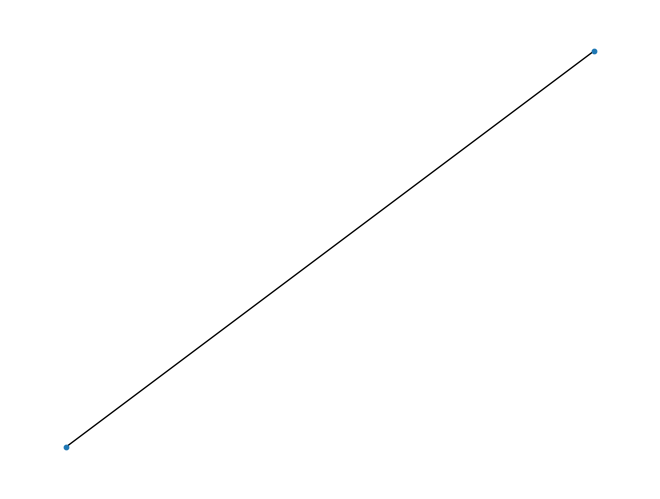

1


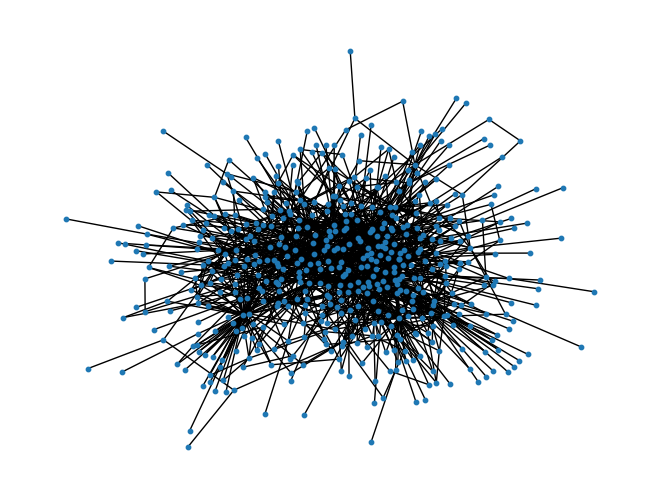

1


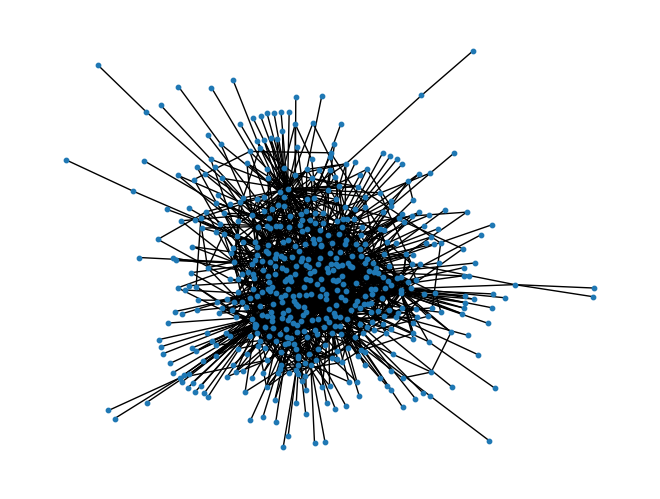

4


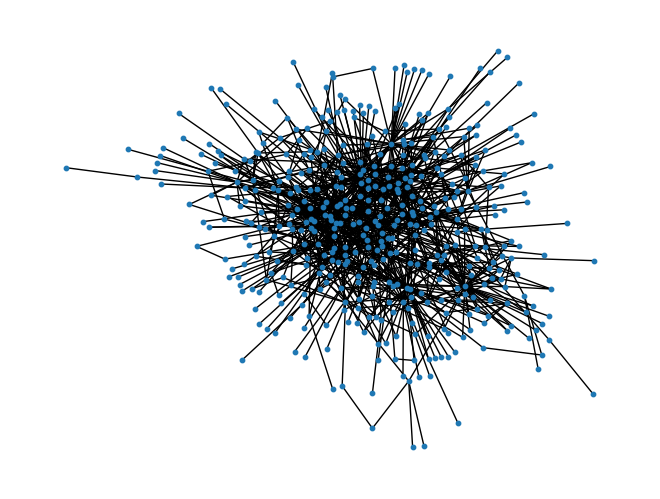

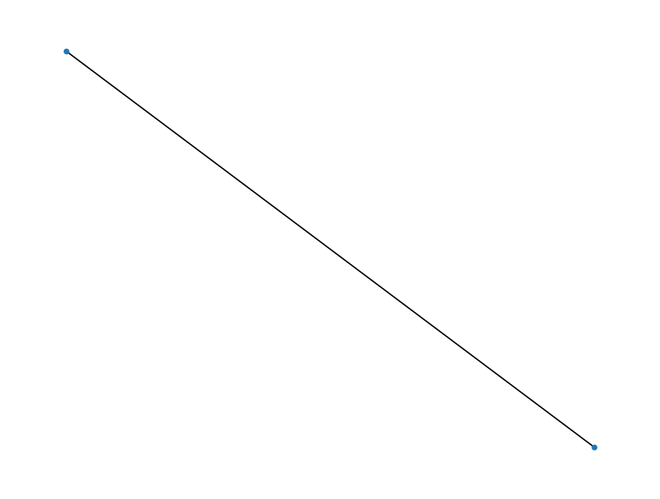

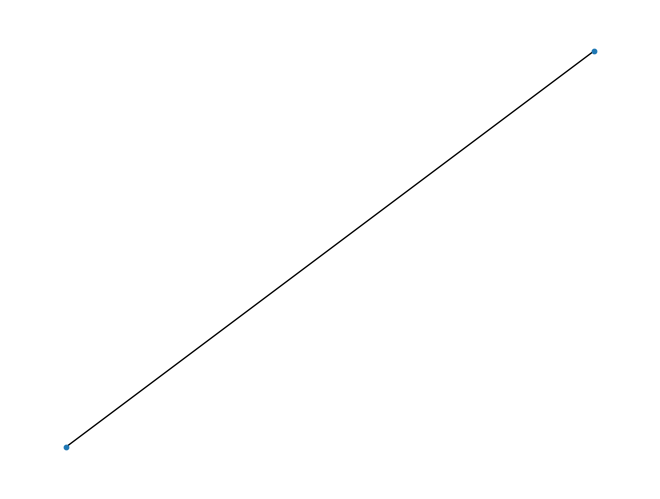

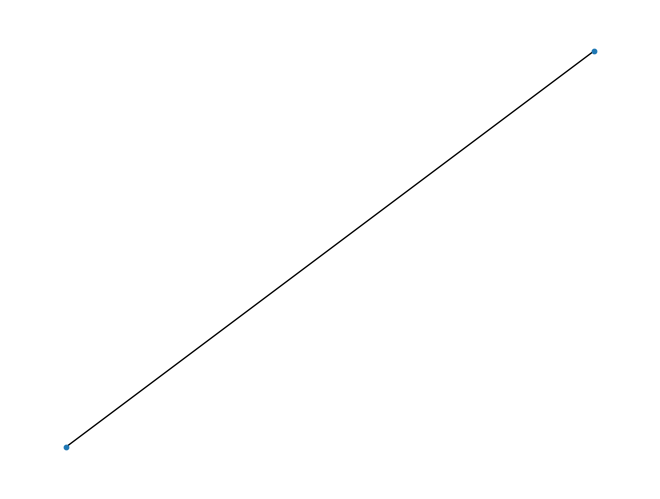

1


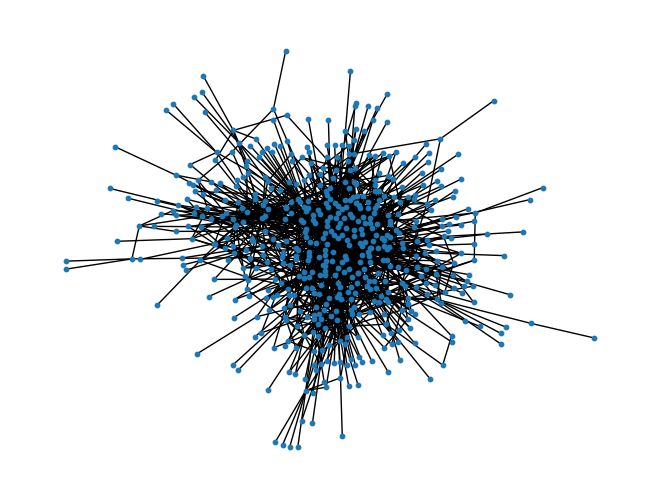

2


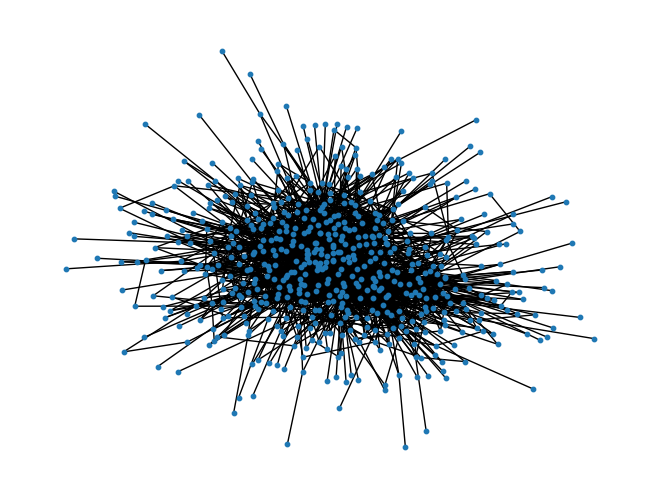

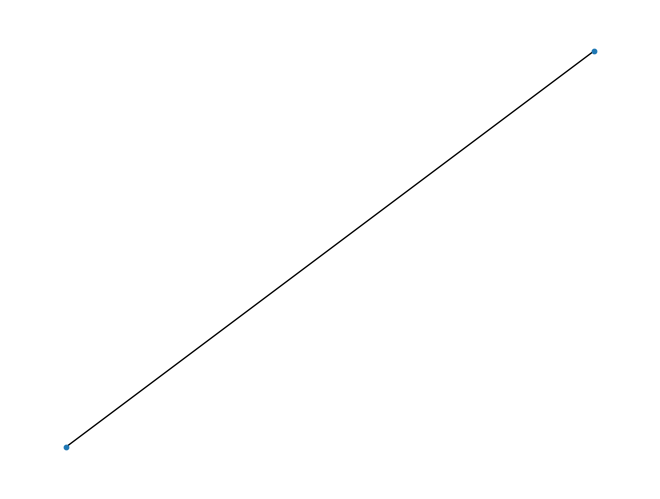

1


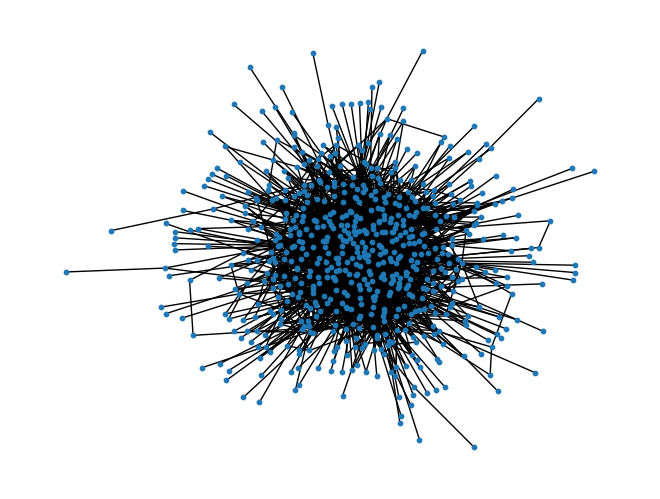

3


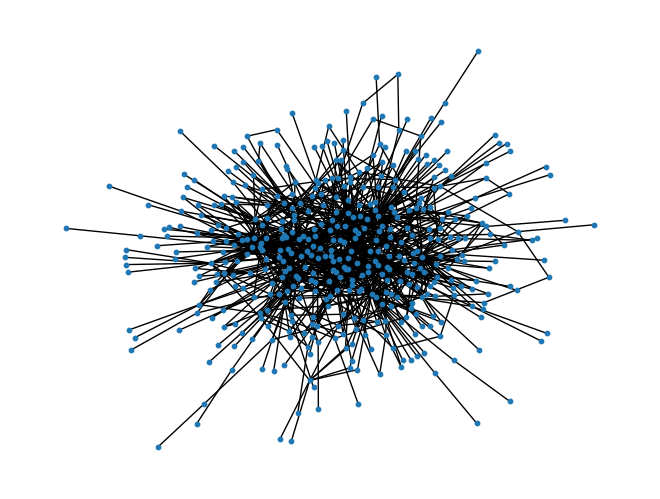

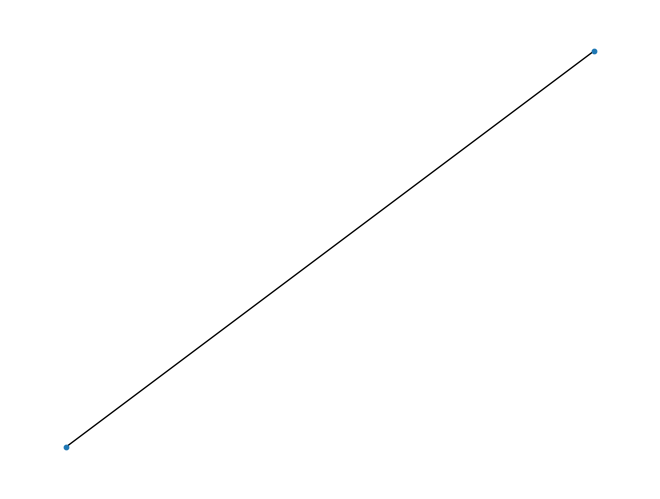

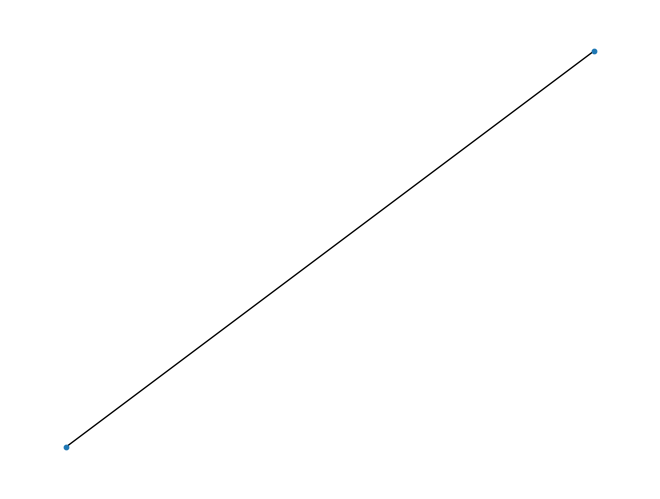

In [7]:
# THis displays the disconnected networks.
for graph in graphs_year_qa:
  g = [graph.subgraph(c).copy() for c in nx.connected_components(graph)] # Only work for undirected graphs
  print(len(g))
  for i in g:
    nx.draw(i, node_size=10)

    plt.show()


The year: 2006
The largest disconnected Q&A graph: 


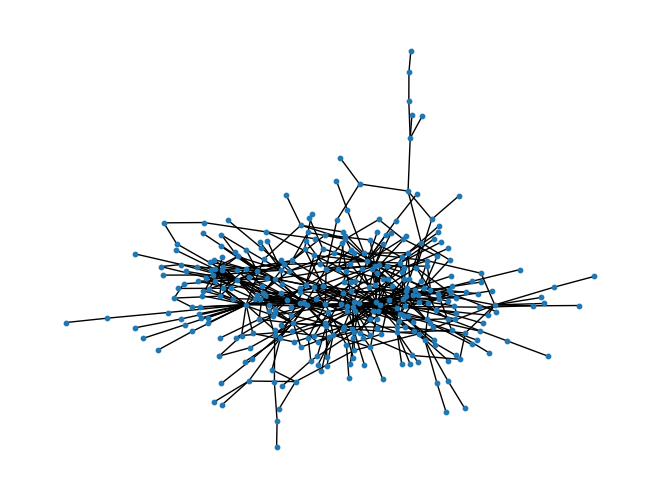

The year: 2007
The largest disconnected Q&A graph: 


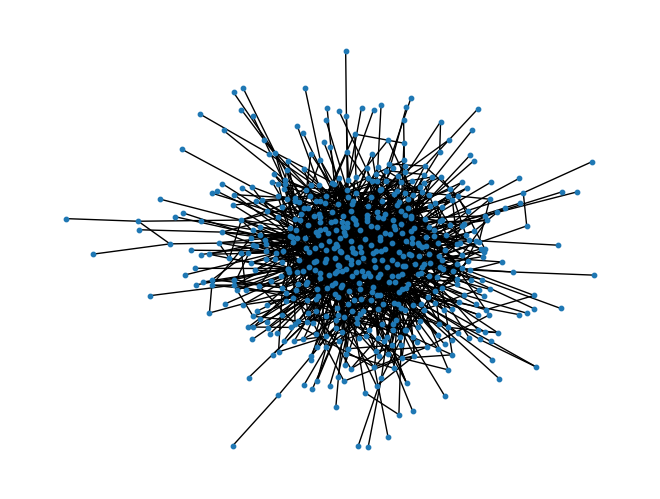

The year: 2008
The largest disconnected Q&A graph: 


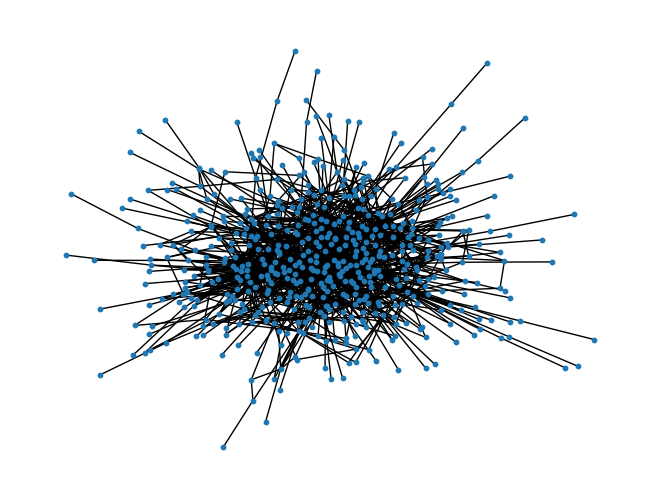

The year: 2009
The largest disconnected Q&A graph: 


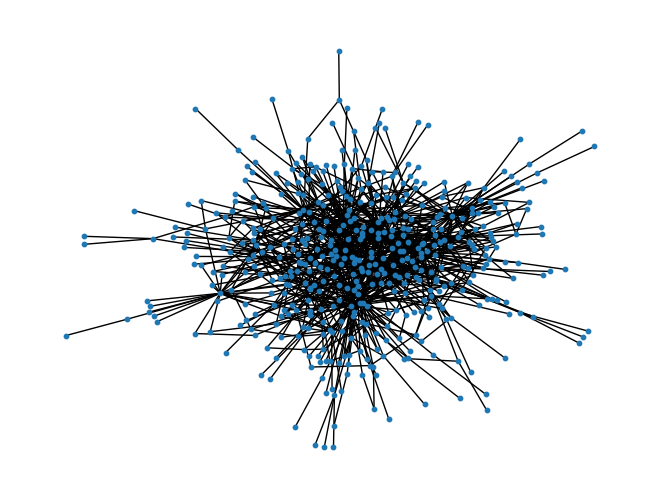

The year: 2010
The largest disconnected Q&A graph: 


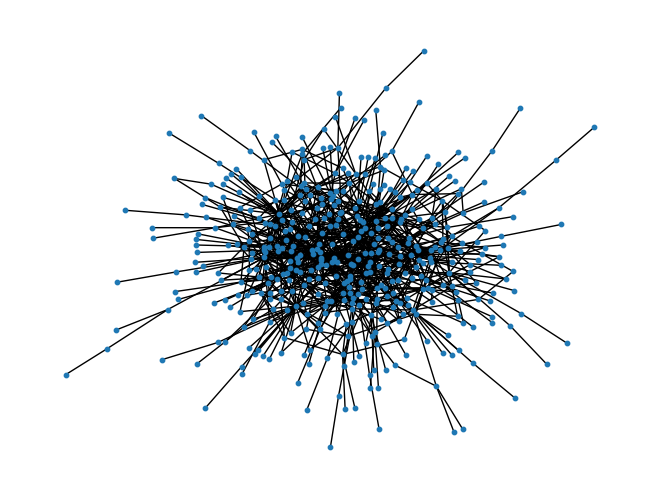

The year: 2011
The largest disconnected Q&A graph: 


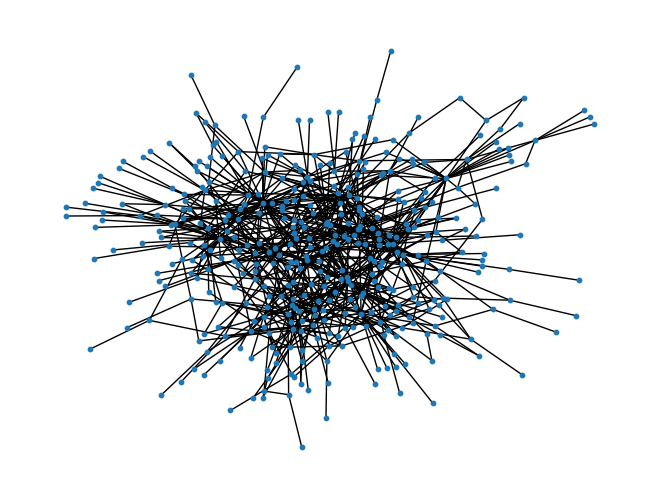

The year: 2012
The largest disconnected Q&A graph: 


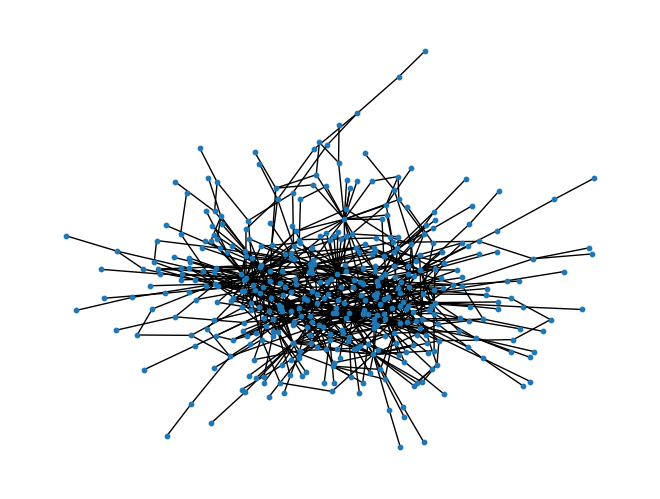

The year: 2013
The largest disconnected Q&A graph: 


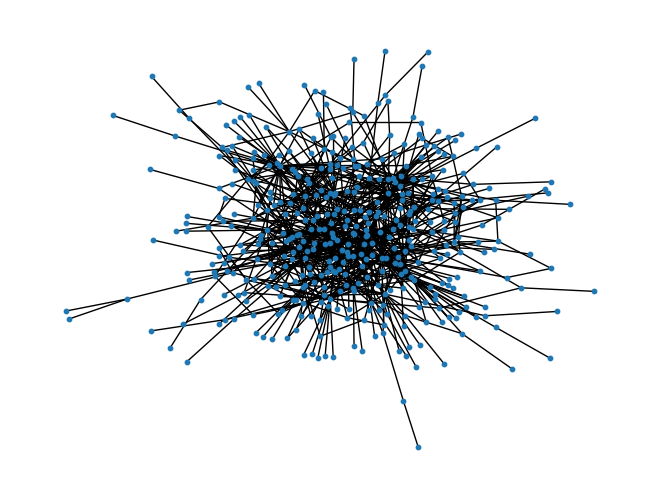

The year: 2014
The largest disconnected Q&A graph: 


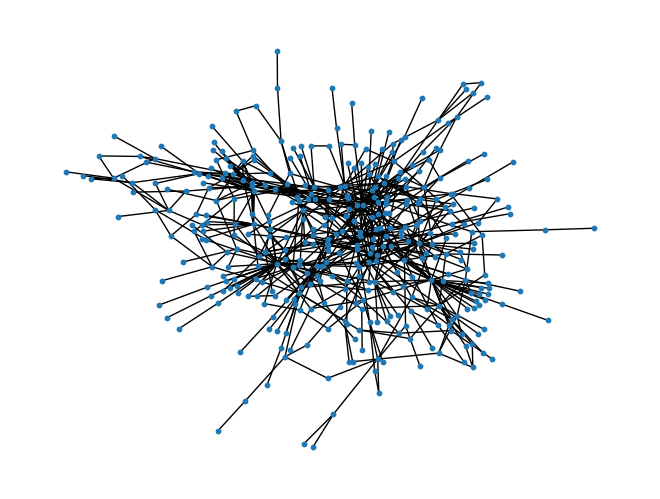

The year: 2015
The largest disconnected Q&A graph: 


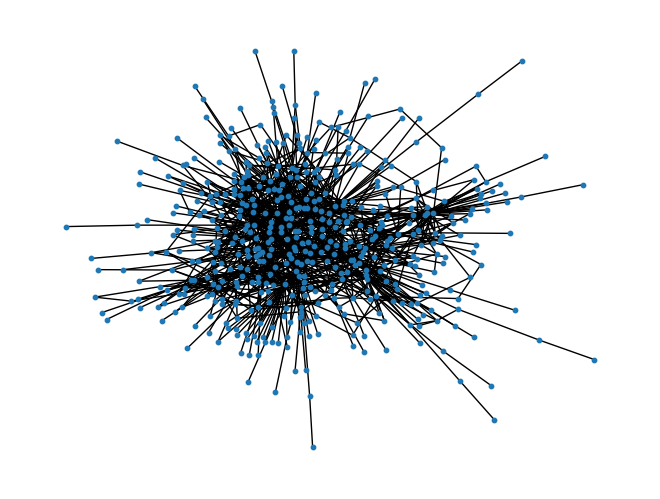

The year: 2016
The largest disconnected Q&A graph: 


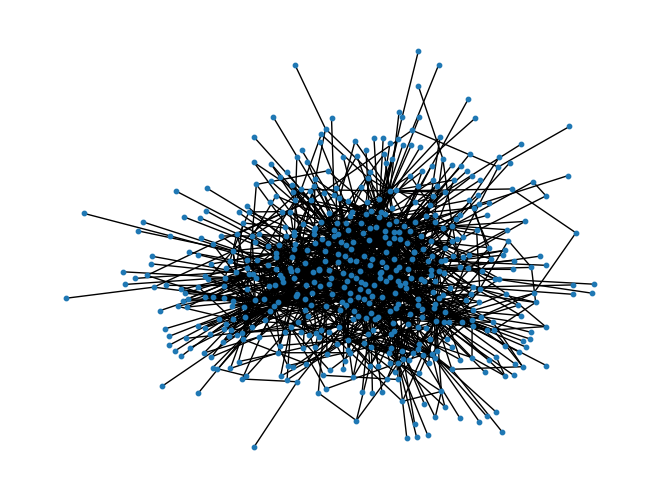

The year: 2017
The largest disconnected Q&A graph: 


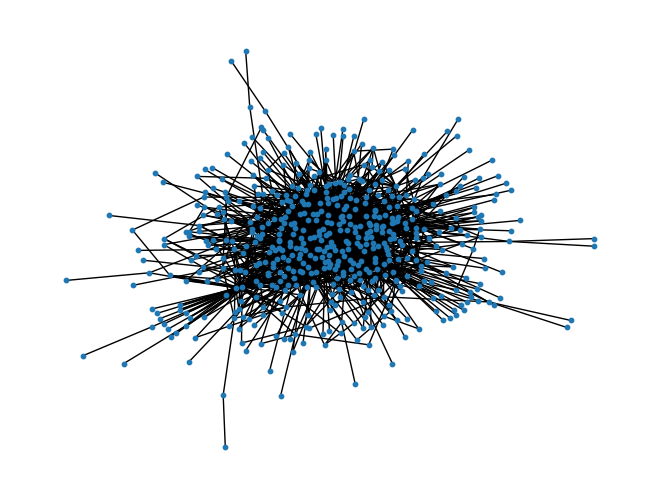

The year: 2018
The largest disconnected Q&A graph: 


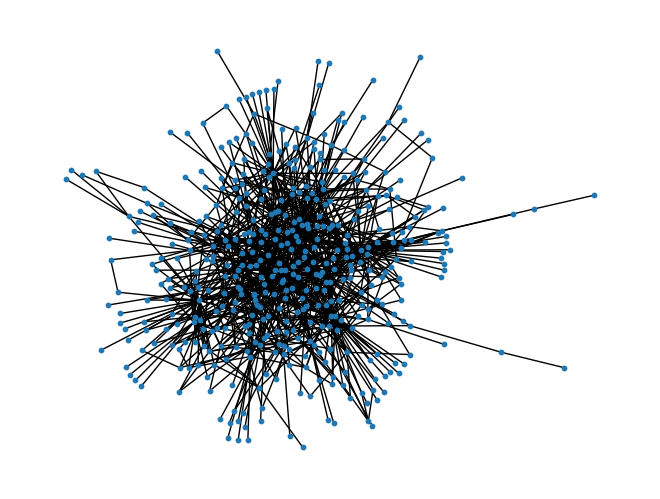

The year: 2019
The largest disconnected Q&A graph: 


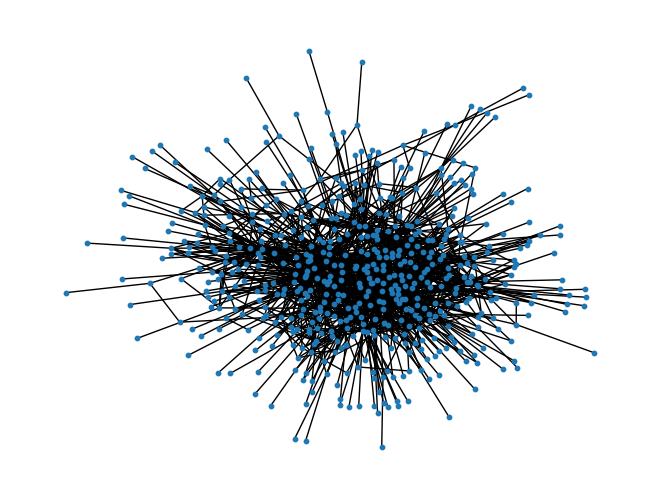

The year: 2020
The largest disconnected Q&A graph: 


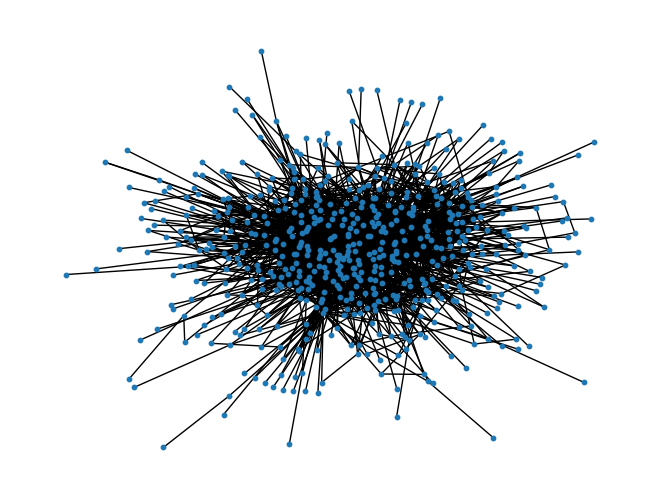

The year: 2021
The largest disconnected Q&A graph: 


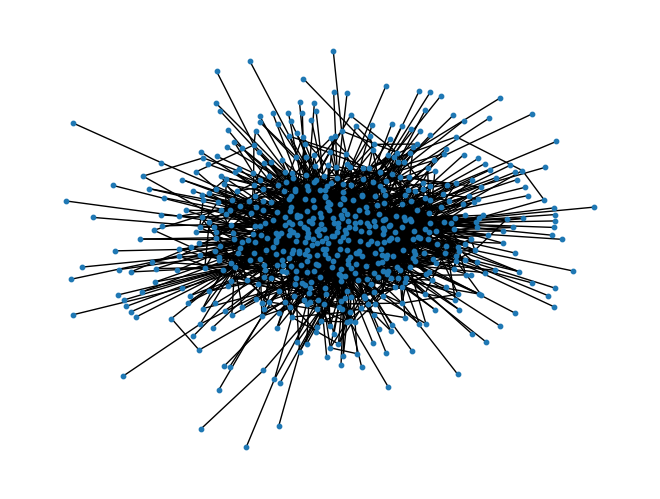

The year: 2022
The largest disconnected Q&A graph: 


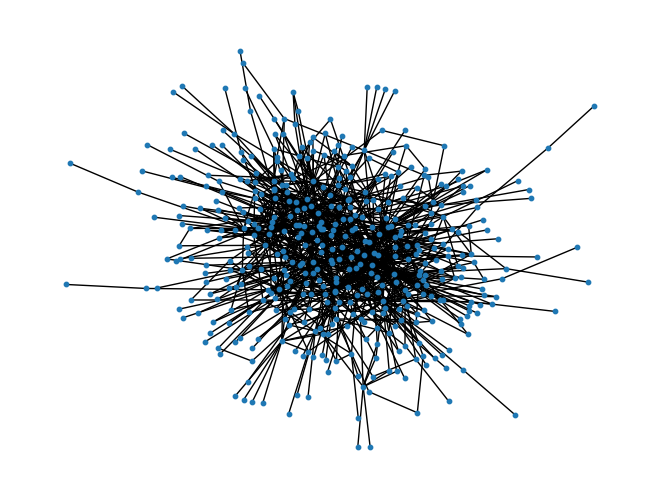

In [8]:
# Gets the largest networks only
for i, graph in enumerate(graphs_year_qa):
  g = max(nx.connected_components(graph), key=len)
  largest_graph = graph.subgraph(g)

  #people, topics = nx.bipartite.sets(largest_connected)
  print(f"The year: {years[i]}")
  print("The largest disconnected Q&A graph: ")

  nx.draw(largest_graph,node_size=10)
  plt.show()

## Create a projected network

In [10]:
# Weighted networks. This takes the weighed projected networks for the people asking or answering questions

# Through the YEARS
# Combined
people_proj_year_comb = []
for graph in graphs_year_comb:
  people, topics = bipartite.sets(graph)
  graph_people = bipartite.weighted_projected_graph(graph, people)
  people_proj_year_comb.append(graph_people)

# Questions and answers
nr_underected = []
people_proj_year_qa_largest = []
people_proj_year_qa = []
graphs_year_qa_largest = []

for graph in graphs_year_qa:
  # One way to handle this is to either add all disconnected graphs to a list for each period or take the one who is largest.
  # Take the largest:
  largest_connected = max(nx.connected_components(graph), key=len)
  largest_connected = graph.subgraph(largest_connected)
  graphs_year_qa_largest.append(largest_connected)

  people, topics = nx.bipartite.sets(largest_connected)
  g_top = nx.bipartite.weighted_projected_graph(largest_connected, people)
  people_proj_year_qa_largest.append(g_top)

  # Or create a list of all subgraphs for each time period
  sub_graphs = [graph.subgraph(c).copy() for c in nx.connected_components(graph)] # Only work for undirected graphs
  nr_underected.append(len(sub_graphs))
  projections = []
  for sub_graph in sub_graphs:
    if nx.is_bipartite(sub_graph):
      people, topics = nx.bipartite.sets(sub_graph)
      g_top = nx.bipartite.weighted_projected_graph(sub_graph, people)
      projections.append(g_top)
    else:
      print(f"The graph is not bipartite.")
      projections.append("not bipartite")
  people_proj_year_qa.append(projections)

# Questions and answers
nr_underected_e_qa = []
graphs_e_qa_largest = []
people_proj_e_qa_largest = []
people_proj_e_qa = []

for graph in graphs_e_qa:
  # One way to handle this is to either add all disconnected graphs to a list for each period or take the one who is largest.
  # Take the largest:
  largest_connected = max(nx.connected_components(graph), key=len)
  largest_connected = graph.subgraph(largest_connected)

  graphs_e_qa_largest.append(largest_connected)

  people, topics = nx.bipartite.sets(largest_connected)
  g_top = nx.bipartite.weighted_projected_graph(largest_connected, people)
  people_proj_e_qa_largest.append(g_top)

  # Or create a list of all subgraphs for each time period
  sub_graphs = [graph.subgraph(c).copy() for c in nx.connected_components(graph)] # Only work for undirected graphs
  nr_underected_e_qa.append(len(sub_graphs))
  projections = []
  for sub_graph in sub_graphs:
    if nx.is_bipartite(sub_graph):
      people, topics = nx.bipartite.sets(sub_graph)
      g_top = nx.bipartite.weighted_projected_graph(sub_graph, people)
      projections.append(g_top)
    else:
      print(f"The graph is not bipartite.")
      projections.append("not bipartite")
  people_proj_e_qa.append(projections)

## Communities
Get the communities of the graphs. 

In [15]:
from community import community_louvain # Can be installed with pip install python-louvain
from collections import defaultdict

# A function that get the communities of list of graph. It assigns each node a community value by using the Louvain community detection algorithm. 
# For each graph it throughout the time periods it returns two lists:
# communities - The partition of the network into communities with keys being nodes in the input graph, and values are the corresponding community assignments for that node.
#               ex: 'Ulf Berg': 3,'Sven Otto Littorin': 1, 'Fredrik Lundh': 4

# people_in_communities - a dict where each key is a community number and the value is a list of people that belongs to that number
def get_communities_combined(graphs):
  people_in_communities = []
  communities = []

  for i, graph in enumerate(graphs):
    people, topics = bipartite.sets(graph)
    graph_people = bipartite.weighted_projected_graph(graph, people)
    community = community_louvain.best_partition(graph_people)
    communities.append(community)
      
    new_dict = defaultdict(list)
    for k, v in community.items():
        new_dict[v].append(k)
    people_in_communities.append(new_dict)

  return people_in_communities, communities

# A list containing the top (3) communities for each graph. Can also return all communities
def get_community_values(people_in_communities, all=False):
  top_communities_lst = []
  for com in people_in_communities:
    top_communities = []

    sorted_communites = sorted(dict(com).items(), key=lambda x: len(x[1]), reverse=True)
    if not all:
      for key in sorted_communites[:3]:
        top_communities.append(key[0])
    else:
      for key in sorted_communites:
        top_communities.append(key[0])
    top_communities_lst.append(top_communities)

  return top_communities_lst


# Returns a dict of each parties top three comunities throughout the periods
def get_parties_communities(top_communities_lst, people_in_communities, graphs, data):
  parties_communities = {'S':[], 'V':[],'MP':[],'C':[],'L':[],'M':[], 'KD':[], 'SD':[],'-':[], 'all':[]}
  size_top_comm = []

  for i, graph in enumerate(graphs):  # i is each period
    S_lst = []
    V_lst = []
    MP_lst = []
    C_lst = []
    L_lst = []
    M_lst = []
    KD_lst = []
    SD_lst = []
    no_party_lst = []
    all_lst = []
    for com in top_communities_lst[i]: # com - (list) of top three communities
      S = V = MP = C = L = M = KD = SD = no_party= all = 0

      # find the parties of the people in the communities
      for people in people_in_communities[i][com]:
        if graph.nodes[people]['party'] == 'S':
          S += 1
        if graph.nodes[people]['party'] == 'V':
          V += 1
        if graph.nodes[people]['party'] == 'MP':
          MP += 1
        if graph.nodes[people]['party'] == 'C':
          C += 1
        if graph.nodes[people]['party'] == 'L':
          L += 1
        if graph.nodes[people]['party'] == 'M':
          M += 1
        if graph.nodes[people]['party'] == 'KD':
          KD += 1
        if graph.nodes[people]['party'] == 'SD':
          SD += 1
        if graph.nodes[people]['party'] == '-':
          no_party += 1
        all += 1

      S_lst.append(S)
      V_lst.append(V)
      MP_lst.append(MP)
      C_lst.append(C)
      L_lst.append(L)
      M_lst.append(M)
      KD_lst.append(KD)
      SD_lst.append(SD)
      no_party_lst.append(no_party)
      all_lst.append(all)
    parties_communities['S'].append(S_lst)
    parties_communities['V'].append(V_lst)
    parties_communities['MP'].append(MP_lst)
    parties_communities['C'].append(C_lst)
    parties_communities['L'].append(L_lst)
    parties_communities['M'].append(M_lst)
    parties_communities['KD'].append(KD_lst)
    parties_communities['SD'].append(SD_lst)
    parties_communities['-'].append(no_party_lst)
    parties_communities['all'].append(all_lst)
  return parties_communities

Find the communies and take each parties share thats in the top three communities.

In [16]:
# Divides a parties number of people in a specific community with the parties total amount of people in all communities
def party_share(party, party_value, i, graph, people_in_communities):
  party_count = 0

  for key, value in people_in_communities[i].items():
    for people in value:
      if graph.nodes[people]['party'] == party:
        party_count += 1
  if party_count != 0:
    result = party_value/party_count
    return result
  else:
    return 0

# Returns a dict of each parties top comunities throughour the periods with shares.
def get_parties_communities_share(top_communities_lst, people_in_communities, graphs, data):
  parties_communities = {'S':[], 'V':[],'MP':[],'C':[],'L':[],'M':[], 'KD':[], 'SD':[],'-':[]}
  size_top_comm = []

  for i, graph in enumerate(graphs): 
    S_lst = []
    V_lst = []
    MP_lst = []
    C_lst = []
    L_lst = []
    M_lst = []
    KD_lst = []
    SD_lst = []
    no_party_lst = []
    for com in top_communities_lst[i]:
      S = V = MP = C = L = M = KD = SD = no_party = 0


      for people in people_in_communities[i][com]:
        if graph.nodes[people]['party'] == 'S':
          S += 1
        if graph.nodes[people]['party'] == 'V':
          V += 1
        if graph.nodes[people]['party'] == 'MP':
          MP += 1
        if graph.nodes[people]['party'] == 'C':
          C += 1
        if graph.nodes[people]['party'] == 'L':
          L += 1
        if graph.nodes[people]['party'] == 'M':
          M += 1
        if graph.nodes[people]['party'] == 'KD':
          KD += 1
        if graph.nodes[people]['party'] == 'SD':
          SD += 1
        if graph.nodes[people]['party'] == '-':
          no_party += 1

      S_lst.append(party_share('S', S, i, graph, people_in_communities))
      V_lst.append(party_share('V', V, i, graph, people_in_communities))
      MP_lst.append(party_share('MP', MP, i, graph, people_in_communities))
      C_lst.append(party_share('C', C, i, graph, people_in_communities))
      L_lst.append(party_share('L', L, i, graph, people_in_communities))
      M_lst.append(party_share('M', M, i, graph, people_in_communities))
      KD_lst.append(party_share('KD', KD, i, graph, people_in_communities))
      SD_lst.append(party_share('SD', SD, i, graph, people_in_communities))
      no_party_lst.append(party_share('-', no_party, i, graph, people_in_communities))

    parties_communities['S'].append(S_lst)
    parties_communities['V'].append(V_lst)
    parties_communities['MP'].append(MP_lst)
    parties_communities['C'].append(C_lst)
    parties_communities['L'].append(L_lst)
    parties_communities['M'].append(M_lst)
    parties_communities['KD'].append(KD_lst)
    parties_communities['SD'].append(SD_lst)
    parties_communities['-'].append(no_party_lst)

  return parties_communities


In [17]:
# 1. Years: This gets the communities in the period years and with the combined graph.
people_in_communities, communities = get_communities_combined(graphs_year_comb)
top_com_years = get_community_values(people_in_communities)

parties_communities_years_shares = get_parties_communities_share(top_com_years, people_in_communities, graphs_year_comb, data_years)

parties_communities_years = get_parties_communities(top_com_years, people_in_communities, graphs_year_comb, data_years)


In [18]:
print(f"amount of years: {len(parties_communities_years_shares['S'])}")
parties_communities_years_shares['S']

amount of years: 17


[[0.23214285714285715, 0.125, 0.19642857142857142],
 [0.20192307692307693, 0.22115384615384615, 0.25961538461538464],
 [0.2826086956521739, 0.1956521739130435, 0.13043478260869565],
 [0.21505376344086022, 0.25806451612903225, 0.16129032258064516],
 [0.23300970873786409, 0.1553398058252427, 0.14563106796116504],
 [0.2625, 0.225, 0.175],
 [0.20481927710843373, 0.13253012048192772, 0.18072289156626506],
 [0.2727272727272727, 0.2222222222222222, 0.23232323232323232],
 [0.2247191011235955, 0.2808988764044944, 0.21348314606741572],
 [0.2714285714285714, 0.32857142857142857, 0.11428571428571428],
 [0.359375, 0.140625, 0.15625],
 [0.2, 0.2153846153846154, 0.18461538461538463],
 [0.18604651162790697, 0.11627906976744186, 0.18604651162790697],
 [0.3090909090909091, 0.21818181818181817, 0.23636363636363636],
 [0.43243243243243246, 0.13513513513513514, 0.21621621621621623],
 [0.25, 0.32142857142857145, 0.17857142857142858],
 [0.39473684210526316, 0.13157894736842105, 0.13157894736842105]]

In [ ]:
def plot_communities(parties_communities, x_val):

  bar_width = 0.2

  for i in range(3):
    S = [item[i] for item in parties_communities['S']]
    V = [item[i] for item in parties_communities['V']]
    MP = [item[i] for item in parties_communities['MP']]
    C = [item[i] for item in parties_communities['C']]
    L = [item[i] for item in parties_communities['L']]
    M = [item[i] for item in parties_communities['M']]
    KD = [item[i] for item in parties_communities['KD']]
    SD = [item[i] for item in parties_communities['SD']]
    no_party = [item[i] for item in parties_communities['-']]

    x = x_val + i * bar_width - bar_width

    # The bars stacked
    plt.bar(x, S, width=bar_width, color="red", edgecolor='black', label="S") # color="#E8112d"
    plt.bar(x, M, width=bar_width, bottom=S, color="#52BDEC", edgecolor='black', label="M")
    plt.bar(x, SD, width=bar_width, bottom=np.array(M)+np.array(S), color="#DDDD00", edgecolor='black', label="SD")
    plt.bar(x, MP, width=bar_width, bottom=np.array(SD)+np.array(M)+np.array(S), color="#83CF39", edgecolor='black', label="MP")
    plt.bar(x, V, width=bar_width, bottom=np.array(MP)+np.array(SD)+np.array(M)+np.array(S), color="darkred", edgecolor='black', label="V") # color="#DA291C"
    plt.bar(x, C, width=bar_width, bottom=np.array(V)+np.array(MP)+np.array(SD)+np.array(M)+np.array(S), color="#009933", edgecolor='black', label="C")
    plt.bar(x, KD, width=bar_width, bottom=np.array(C)+np.array(V)+np.array(MP)+np.array(SD)+np.array(M)+np.array(S), color="#000077", edgecolor='black', label="KD")
    plt.bar(x, L, width=bar_width, bottom=np.array(KD)+np.array(C)+np.array(V)+np.array(MP)+np.array(SD)+np.array(M)+np.array(S), color="#006AB3", edgecolor='black', label="L")
    plt.bar(x, no_party, width=bar_width, bottom=np.array(L)+np.array(KD)+np.array(C)+np.array(V)+np.array(MP)+np.array(SD)+np.array(M)+np.array(S), color="gray", edgecolor='black', label="-")



### Combined graph

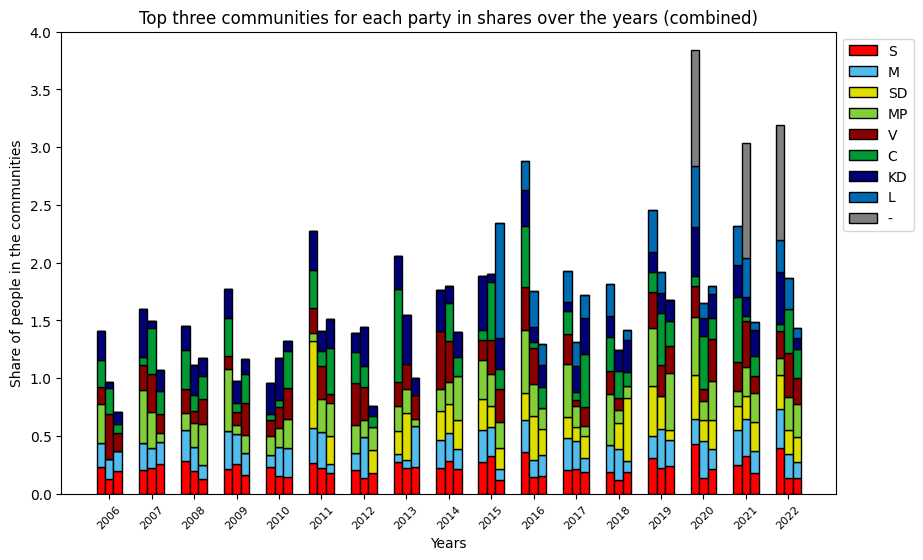

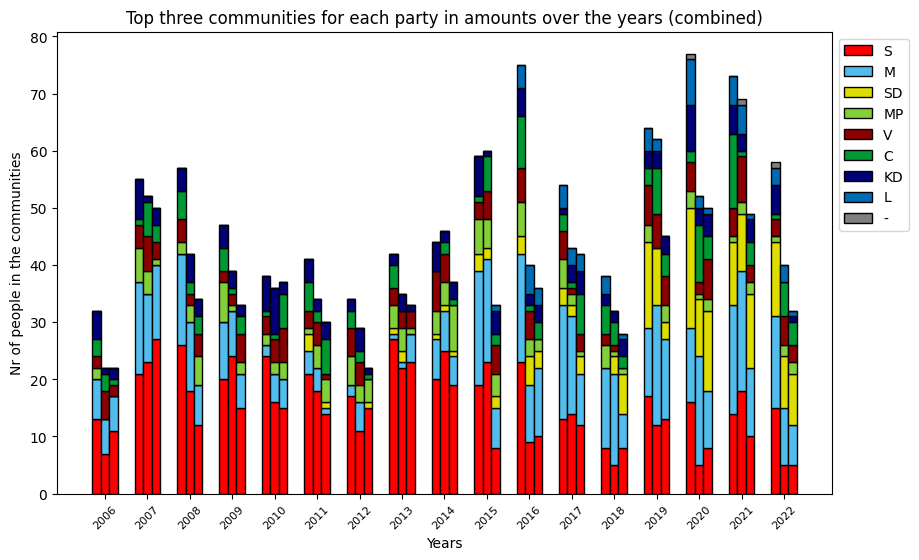

In [21]:
# Plot the top three communities over the years
fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_years_shares['M']) + 1)

plot_communities(parties_communities_years_shares, x_val)

plt.xlabel('Years')
plt.ylabel('Share of people in the communities')
plt.title('Top three communities for each party in shares over the years (combined)')
plt.xticks(x_val, years, rotation=45, fontsize=8)
plt.ylim(0, 4)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_years_shares['M']) + 1)

plot_communities(parties_communities_years, x_val)

plt.xlabel('Years')
plt.ylabel('Nr of people in the communities')
plt.title('Top three communities for each party in amounts over the years (combined)')
plt.xticks(x_val, years, rotation=45, fontsize=8)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



In [22]:
# 2. Goverments: Combined: This gets the communities in the period goverments and with the combined graph.
people_in_communities_gov, communities_gov = get_communities_combined(graphs_gov_comb)
top_com_gov = get_community_values(people_in_communities_gov)

parties_communities_gov = get_parties_communities(top_com_gov, people_in_communities_gov, graphs_gov_comb, data_gov)

parties_communities_gov_shares = get_parties_communities_share(top_com_gov, people_in_communities_gov, graphs_gov_comb, data_gov)


In [23]:
from pprint import pprint

print(f"Nr of periods: {len(parties_communities_gov['S'])}")
pprint(parties_communities_gov['S'])

print(f"Nr of periods: {len(parties_communities_gov_shares['S'])}")
pprint(parties_communities_gov_shares['S'])

Nr of periods: 5
[[63, 34, 27], [45, 26, 30], [28, 22, 20], [11, 3, 2], [15, 13, 10]]
Nr of periods: 5
[[0.35, 0.18888888888888888, 0.15],
 [0.3383458646616541, 0.19548872180451127, 0.22556390977443608],
 [0.4, 0.3142857142857143, 0.2857142857142857],
 [0.5238095238095238, 0.14285714285714285, 0.09523809523809523],
 [0.35714285714285715, 0.30952380952380953, 0.23809523809523808]]


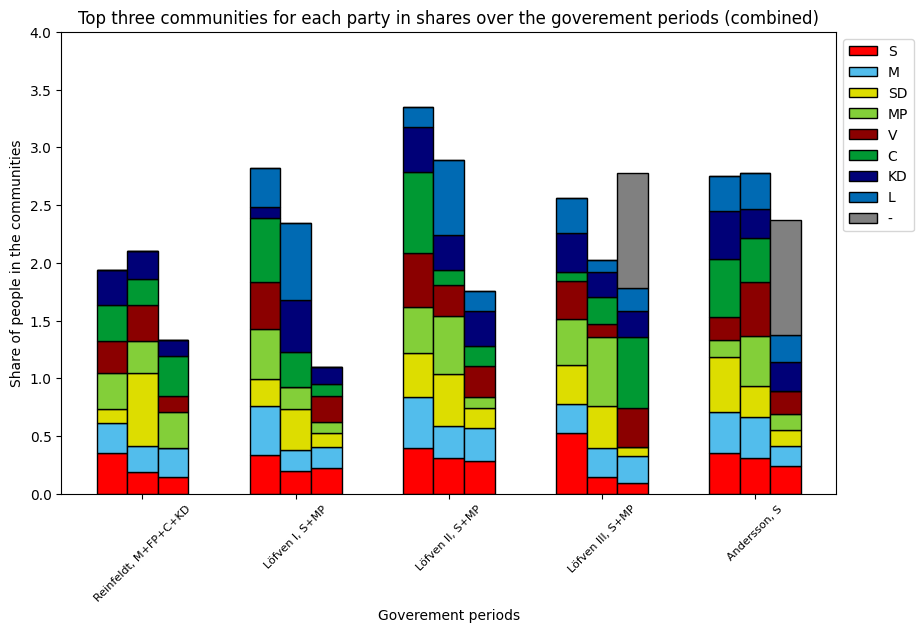

In [27]:
goverment_periods = ["Reinfeldt, M+FP+C+KD","Löfven I, S+MP", "Löfven II, S+MP", "Löfven III, S+MP", "Andersson, S"]
# Plot over the goverment periods
fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_gov_shares['M']) + 1)

plot_communities(parties_communities_gov_shares, x_val)

plt.xlabel('Goverement periods')
plt.ylabel('Share of people in the communities')
plt.title('Top three communities for each party in shares over the goverement periods (combined)')
plt.xticks(x_val, goverment_periods, rotation=45, fontsize=8)
plt.ylim(0, 4)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# It's not reasonable to take the count because the goverment period is of different length, hence, different amount of datapoints.

# fig = plt.figure(figsize=(10, 6))

# plot_communities(parties_communities_gov, x_val)

# plt.xlabel('Goverement periods')
# plt.ylabel('Nr of people in these communities')
# plt.title('Top three communities for each party in amounts over the goverement periods (combined)')
# plt.xticks(x_val, goverment_periods, rotation=45, fontsize=8)
# plt.ylim(0, 141)
# labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
# plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()


In [28]:
# 3. Elections (Combined)
people_in_communities_e, communities_e = get_communities_combined(graphs_e_comb)
top_com_e = get_community_values(people_in_communities_e)

parties_communities_e_shares = get_parties_communities_share(top_com_e, people_in_communities_e, graphs_e_comb, data_elections)

parties_communities_e = get_parties_communities(top_com_e, people_in_communities_e, graphs_e_comb, data_elections)

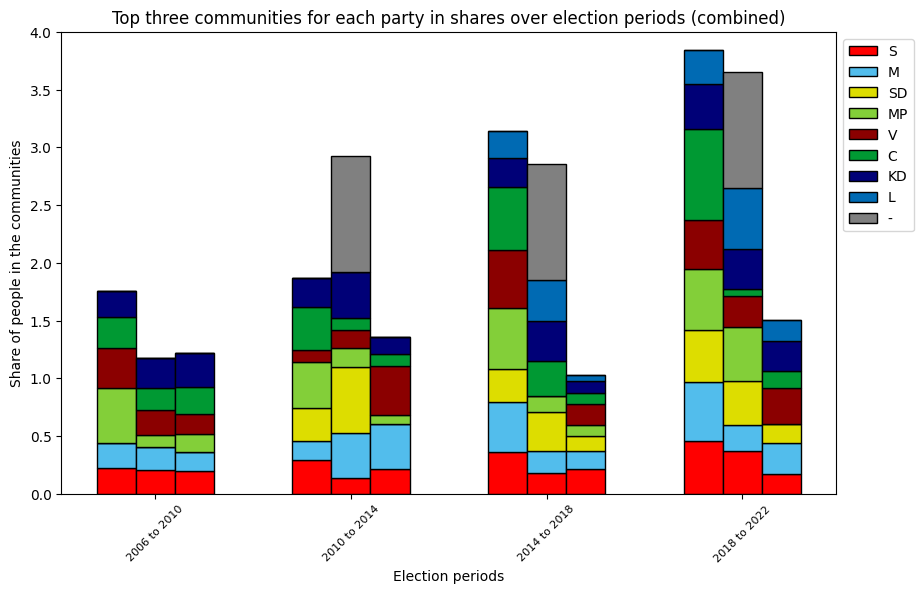

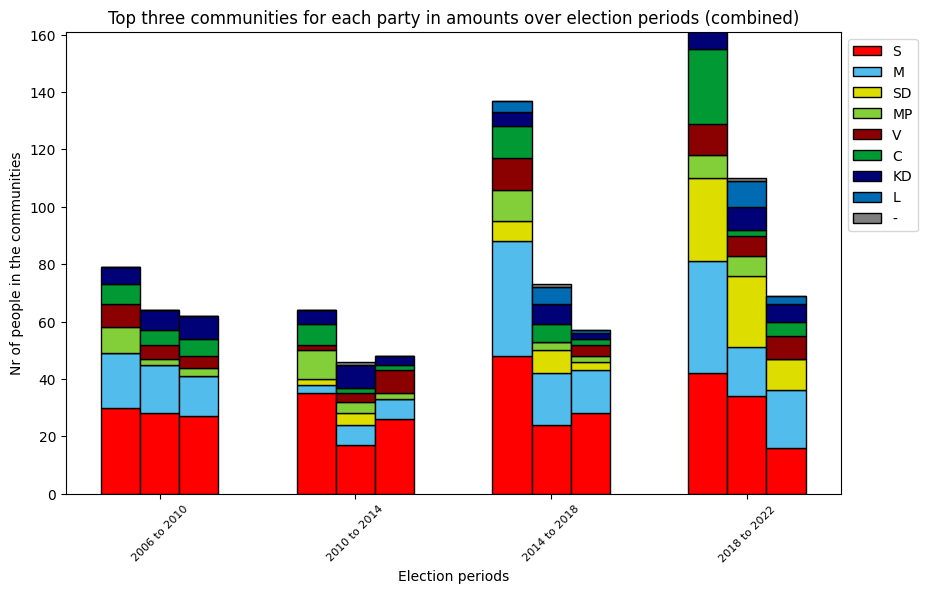

In [30]:
election_interval_name = [ "2006-09-18 to 2010-09-19", "2010-09-20 to 2014-09-14", "2014-09-15 to 2018-09-09", "2018-09-10 to 2022-10-18" ]
election_interval_name = [ "2006 to 2010", "2010 to 2014", "2014 to 2018", "2018 to 2022"]
# Plot over the election periods
fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_e_shares['M']) + 1)

plot_communities(parties_communities_e_shares, x_val)

plt.xlabel('Election periods')
plt.ylabel('Share of people in the communities')
plt.title('Top three communities for each party in shares over election periods (combined)')
plt.xticks(x_val, election_interval_name, rotation=45, fontsize=8)
plt.ylim(0, 4)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

fig = plt.figure(figsize=(10, 6))

plot_communities(parties_communities_e, x_val)

plt.xlabel('Election periods')
plt.ylabel('Nr of people in the communities')
plt.title('Top three communities for each party in amounts over election periods (combined)')
plt.xticks(x_val, election_interval_name, rotation=45, fontsize=8)
plt.ylim(0, 161)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Questions and answers seperate graph

In [32]:
graph_year_qa_largest = []
for graph in graphs_year_qa:
  # One way to handle this is to either add all disconnected graphs to a list for each period or take the one who is largest.
  # Take the largest:
  largest_connected = max(nx.connected_components(graph), key=len)
  largest_connected = graph.subgraph(largest_connected)
  graph_year_qa_largest.append(largest_connected)

graph_gov_qa_largest = []
for graph in graphs_gov_qa:
  # Take the largest:
  largest_connected = max(nx.connected_components(graph), key=len)
  largest_connected = graph.subgraph(largest_connected)
  graph_gov_qa_largest.append(largest_connected)

graph_e_qa_largest = []
for graph in graphs_e_qa:
  # Take the largest:
  largest_connected = max(nx.connected_components(graph), key=len)
  largest_connected = graph.subgraph(largest_connected)
  graph_e_qa_largest.append(largest_connected)

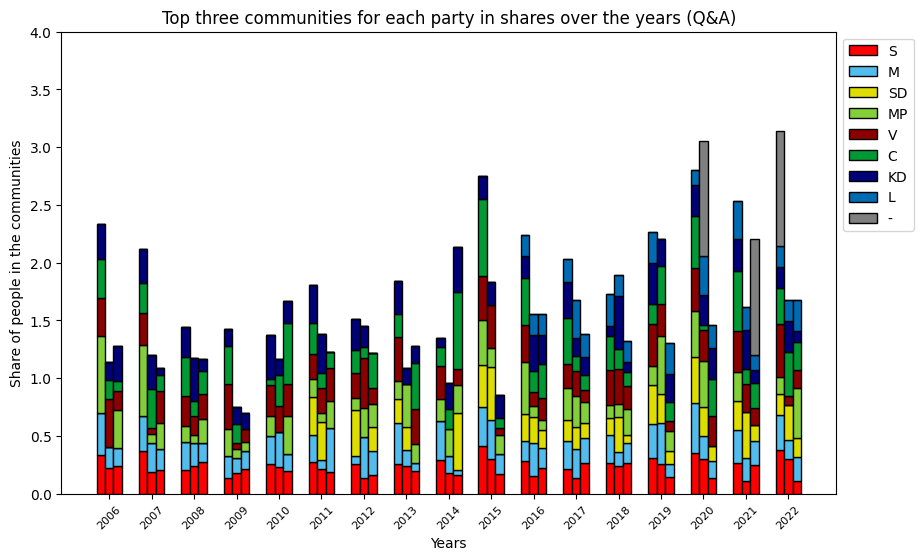

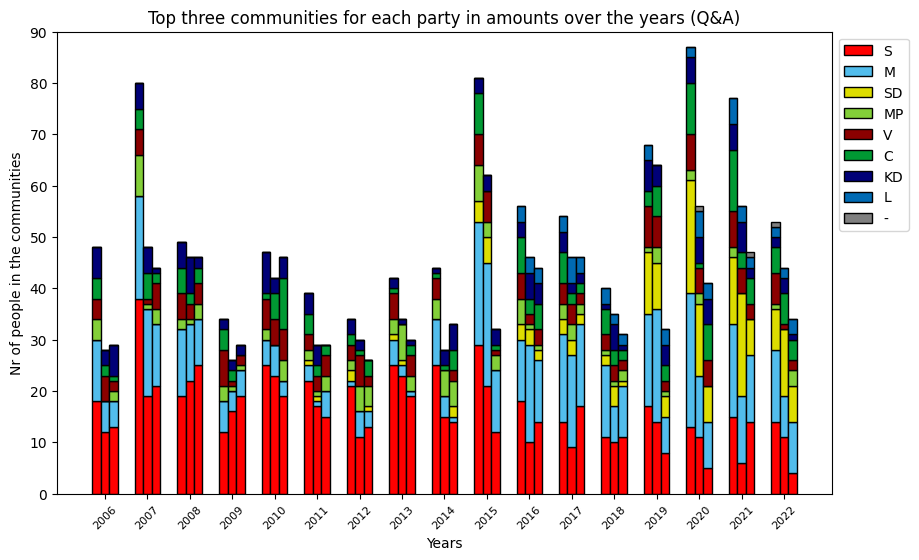

In [34]:
# 1. Years: (questions and answers seperate) This gets the communities over the years.
people_in_communities, communities = get_communities_combined(graph_year_qa_largest)
top_com_years = get_community_values(people_in_communities)

parties_communities_years_shares_qa = get_parties_communities_share(top_com_years, people_in_communities, graph_year_qa_largest, data_years)

parties_communities_years_qa = get_parties_communities(top_com_years, people_in_communities, graph_year_qa_largest, data_years)

# Plotting the share of people in commmunities
fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_years_qa['M']) + 1)

plot_communities(parties_communities_years_shares_qa, x_val)

plt.xlabel('Years')
plt.ylabel('Share of people in the communities')
plt.title('Top three communities for each party in shares over the years (Q&A)')
plt.xticks(x_val, years, rotation=45, fontsize=8)
plt.ylim(0, 4)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Plotting the amount of people in commmunities
fig = plt.figure(figsize=(10, 6))

plot_communities(parties_communities_years_qa, x_val)

plt.xlabel('Years')
plt.ylabel('Nr of people in the communities')
plt.title('Top three communities for each party in amounts over the years (Q&A)')
plt.xticks(x_val, years, rotation=45, fontsize=8)
plt.ylim(0, 90)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [35]:
# 2. Goverments (questions and answers seperate): This gets the communities in the period goverments and with the combined graph.
people_in_communities_gov, communities_gov = get_communities_combined(graph_gov_qa_largest)
top_com_gov = get_community_values(people_in_communities_gov)

parties_communities_gov_shares_qa = get_parties_communities_share(top_com_gov, people_in_communities_gov, graph_gov_qa_largest, data_gov)

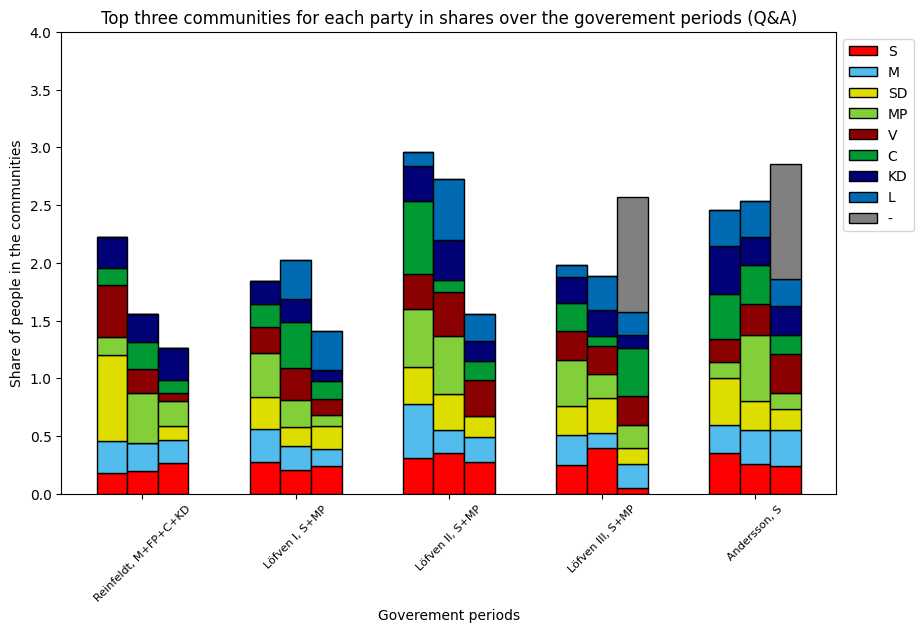

In [37]:
goverment_periods = ["Reinfeldt, M+FP+C+KD","Löfven I, S+MP", "Löfven II, S+MP", "Löfven III, S+MP", "Andersson, S"]

# Plotting the share of people in commmunities
fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_gov_shares_qa['M']) + 1)

plot_communities(parties_communities_gov_shares_qa, x_val)

plt.xlabel('Goverement periods')
plt.ylabel('Share of people in the communities')
plt.title('Top three communities for each party in shares over the goverement periods (Q&A)')
plt.xticks(x_val, goverment_periods, rotation=45, fontsize=8)
plt.ylim(0, 4)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# It's not reasonable to take the count because the goverment period is of different length, hence, different amount of datapoints.

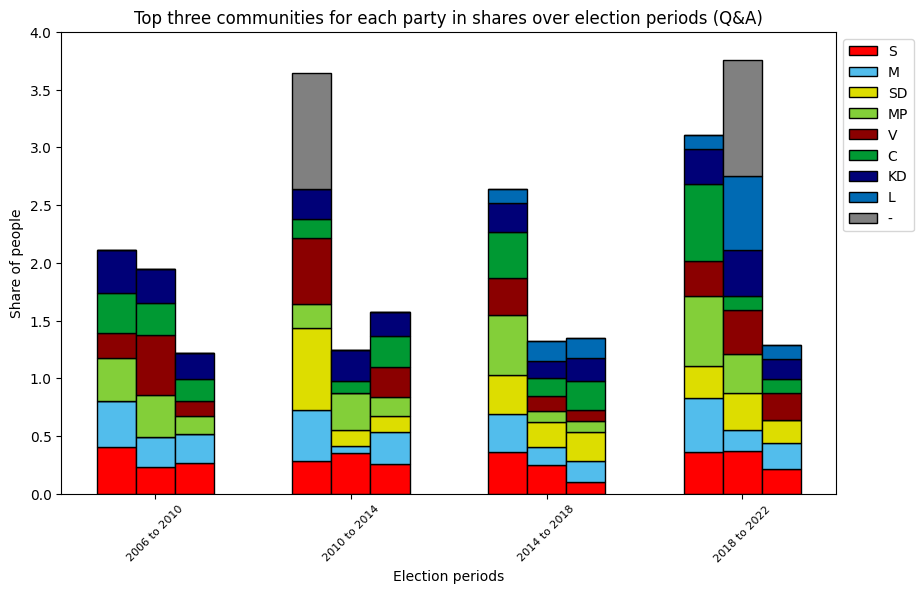

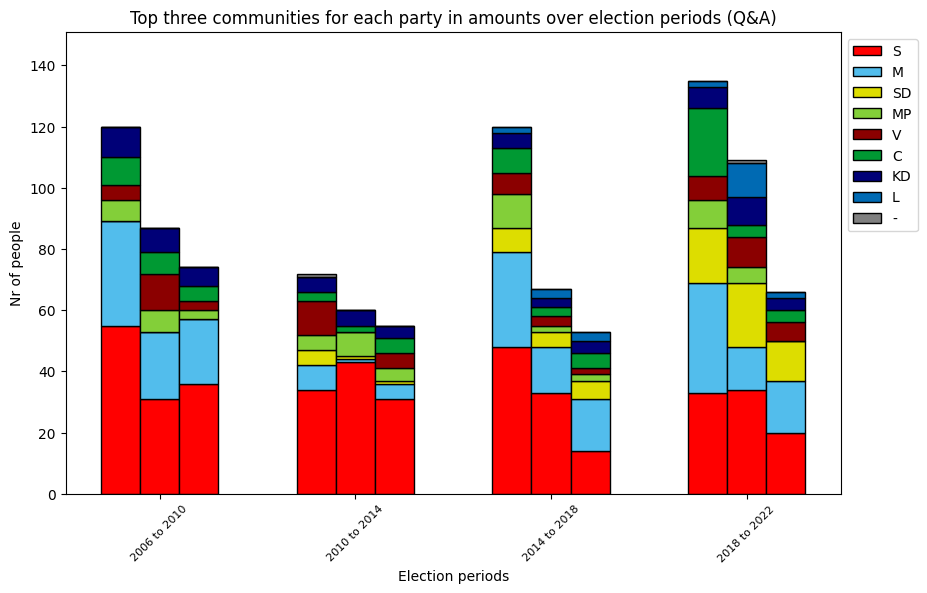

In [38]:
# 3. Elections (questions and answers seperate)
people_in_communities_e, communities_e = get_communities_combined(graph_e_qa_largest)
top_com_e = get_community_values(people_in_communities_e)

parties_communities_e_shares_qa = get_parties_communities_share(top_com_e, people_in_communities_e, graph_e_qa_largest, data_elections)

parties_communities_e_qa = get_parties_communities(top_com_e, people_in_communities_e, graph_e_qa_largest, data_elections)

election_interval_name = [ "2006-09-18 to 2010-09-19", "2010-09-20 to 2014-09-14", "2014-09-15 to 2018-09-09", "2018-09-10 to 2022-10-18" ]
election_interval_name = [ "2006 to 2010", "2010 to 2014", "2014 to 2018", "2018 to 2022"]

# Plot
fig = plt.figure(figsize=(10, 6))

x_val = np.arange(1, len(parties_communities_e_shares_qa['M']) + 1)

plot_communities(parties_communities_e_shares_qa, x_val)

plt.xlabel('Election periods')
plt.ylabel('Share of people')
plt.title('Top three communities for each party in shares over election periods (Q&A)')
plt.xticks(x_val, election_interval_name, rotation=45, fontsize=8)
plt.ylim(0, 4)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

fig = plt.figure(figsize=(10, 6))

plot_communities(parties_communities_e_qa, x_val)

plt.xlabel('Election periods')
plt.ylabel('Nr of people')
plt.title('Top three communities for each party in amounts over election periods (Q&A)')
plt.xticks(x_val, election_interval_name, rotation=45, fontsize=8)
plt.ylim(0, 151)
labels = ['S', 'M', 'SD','MP','V', 'C','KD','L','-']
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Assortativity coefficient or Homophily

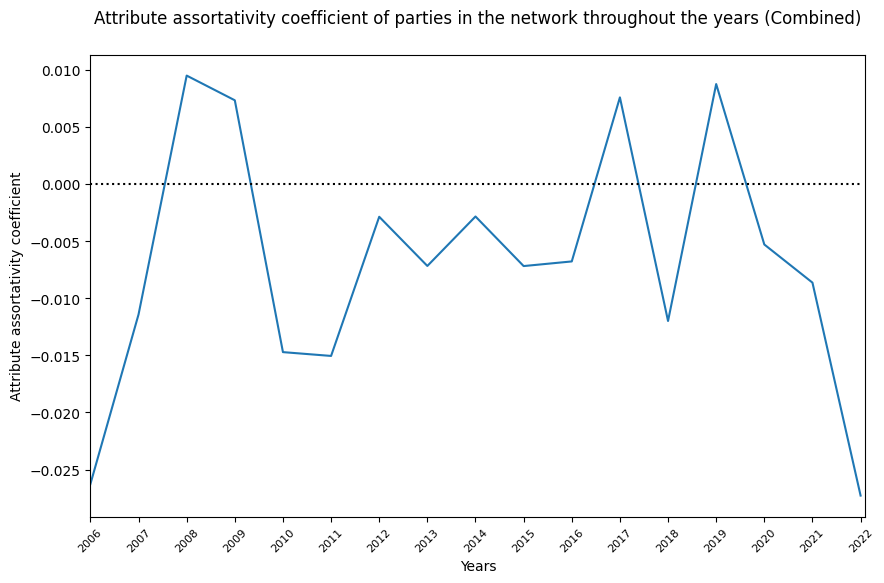

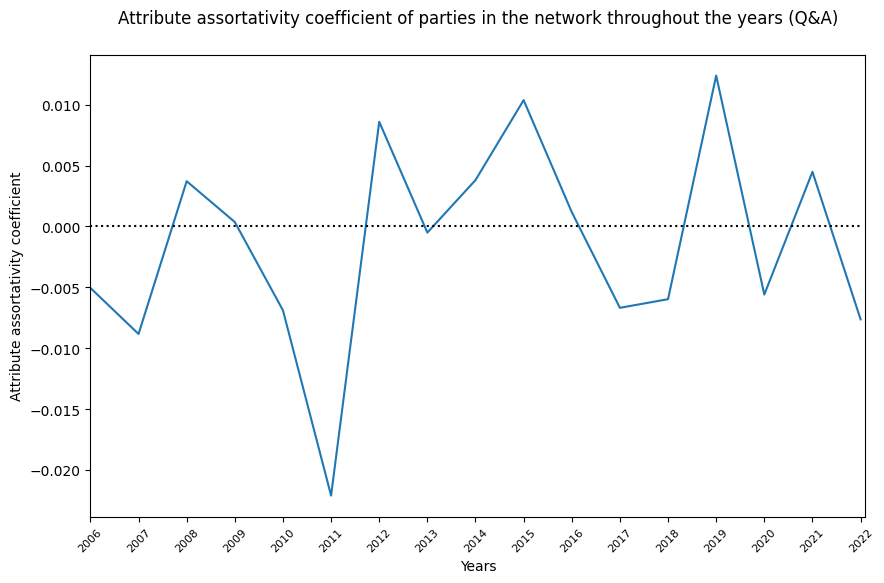

In [39]:
# On attributes
attr_assort_comb = []

for proj in people_proj_year_comb:
  assort = nx.attribute_assortativity_coefficient(proj,'party')
  attr_assort_comb.append(nx.attribute_assortativity_coefficient(proj,'party'))


fig, axs = plt.subplots(figsize=(10, 6))
x = range(0, len(people_proj_year_comb) )
axs.plot(x, attr_assort_comb)
axs.plot(x, ([0] * 17), linestyle='dotted', color='black')


plt.xlabel('Years')
plt.ylabel('Attribute assortativity coefficient')
plt.title('Attribute assortativity coefficient of parties in the network throughout the years (Combined)',y=1.05)
plt.xticks(x, years, rotation=45, fontsize=8)
plt.xlim(0, 16.1)
plt.show()

attr_assort_qa = []
for proj in people_proj_year_qa_largest:
  assort = nx.attribute_assortativity_coefficient(proj, 'party')
  attr_assort_qa.append(assort)

fig, axs = plt.subplots(figsize=(10, 6))
x = range(0, len(people_proj_year_comb) )
axs.plot(x, attr_assort_qa)
axs.plot(x, ([0] * 17), linestyle='dotted', color='black')

plt.xlabel('Years')
plt.ylabel('Attribute assortativity coefficient')
plt.title('Attribute assortativity coefficient of parties in the network throughout the years (Q&A)', y=1.05)
plt.xticks(x, years, rotation=45, fontsize=8)
plt.xlim(0, 16.1)
plt.show()

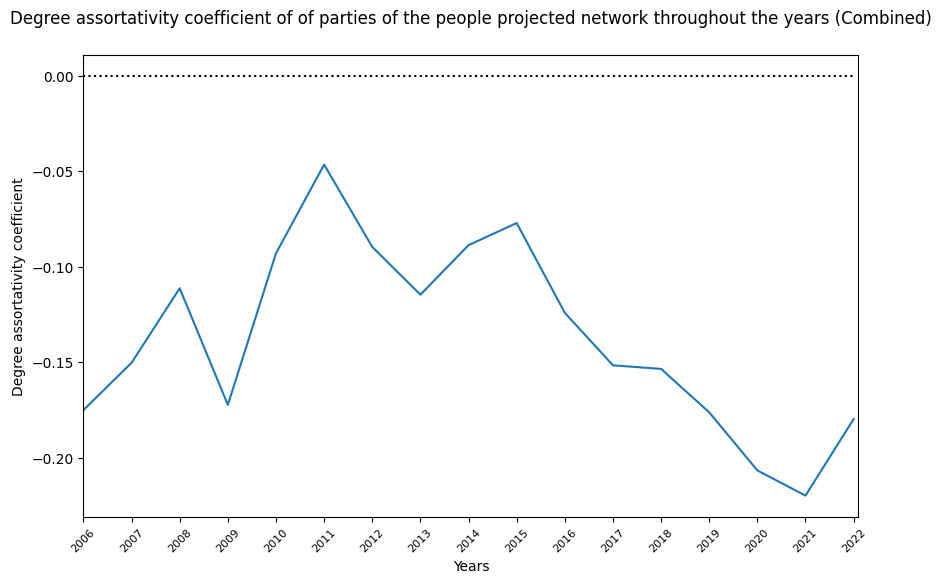

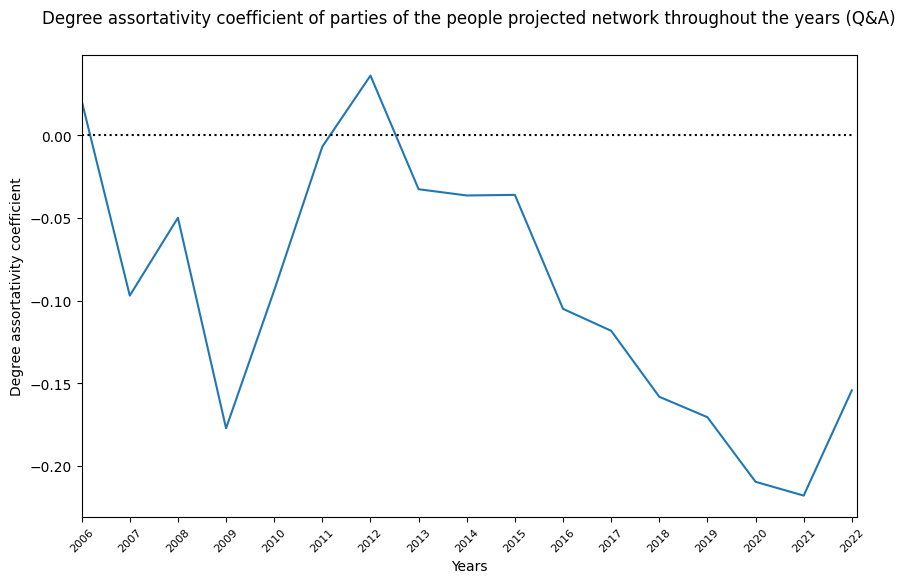

In [43]:
# On degree
degree_assort_comb = []

for proj in people_proj_year_comb:
  assort = nx.degree_assortativity_coefficient(proj)
  degree_assort_comb.append(assort)


fig, axs = plt.subplots(figsize=(10, 6))
x = range(0, len(people_proj_year_comb) )
axs.plot(x, degree_assort_comb)
axs.plot(x, ([0] * 17), linestyle='dotted', color='black')


plt.xlabel('Years')
plt.ylabel('Degree assortativity coefficient')
plt.title('Degree assortativity coefficient of of parties of the people projected network throughout the years (Combined)',y=1.05)
plt.xticks(x, years, rotation=45, fontsize=8)
#plt.ylim(0, 81)
plt.xlim(0, 16.1)
plt.show()

degree_assort_qa = []
for proj in people_proj_year_qa_largest:
  assort = nx.degree_assortativity_coefficient(proj)
  degree_assort_qa.append(assort)

fig, axs = plt.subplots(figsize=(10, 6))
x = range(0, len(people_proj_year_comb) )
axs.plot(x, degree_assort_qa)
axs.plot(x, ([0] * 17), linestyle='dotted', color='black')

plt.xlabel('Years')
plt.ylabel('Degree assortativity coefficient')
plt.title('Degree assortativity coefficient of parties of the people projected network throughout the years (Q&A)', y=1.05)
plt.xticks(x, years, rotation=45, fontsize=8)
plt.xlim(0, 16.1)
plt.show()

## Degree distrubution

### Connectivity

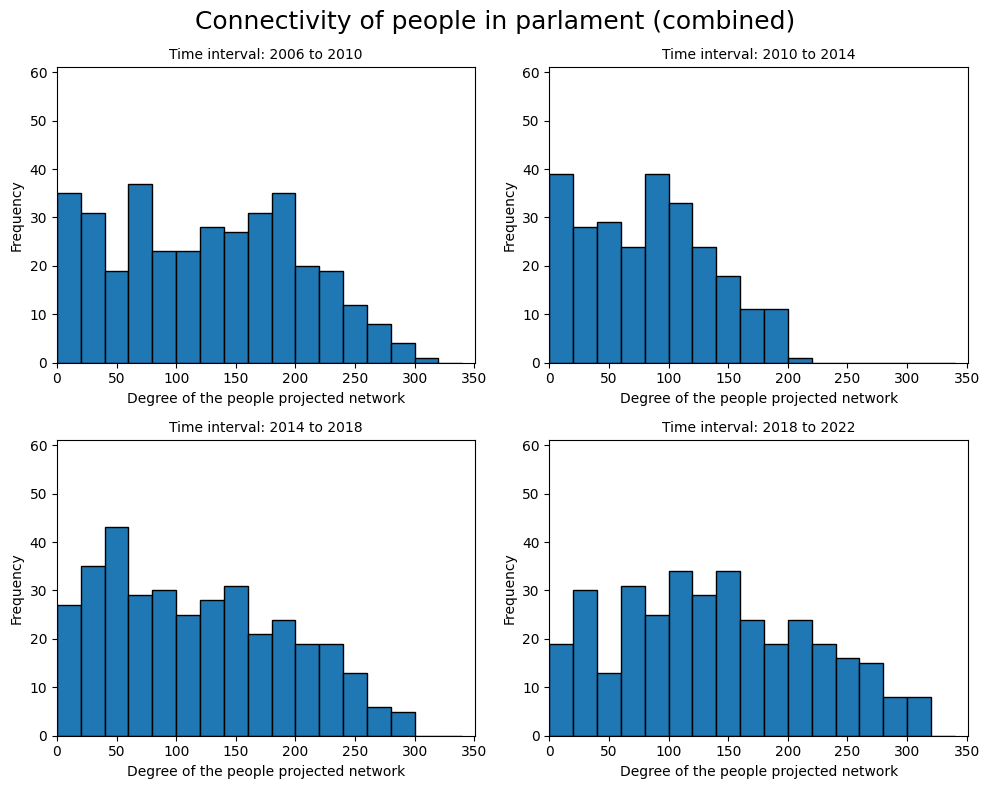

In [49]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
fig.suptitle("Connectivity of people in parlament (combined)", fontsize = 18)

for i, graph in enumerate(graphs_e_comb):
  people, topics = bipartite.sets(graph)
  graph_people = bipartite.weighted_projected_graph(graph, people)
  degree_people = dict((graph_people).degree()).values()
  axs[i].set_xlabel("Degree of the people projected network")
  axs[i].set_xlim(0, 351)
  axs[i].set_xticks(range(0,351,50))
  axs[i].set_ylabel("Frequency")
  axs[i].set_ylim(0, 61)
  axs[i].set_title(f"Time interval: {election_interval_name[i]}", fontsize=10)
  axs[i].hist(degree_people, edgecolor="black", bins=range(0,351,20))

plt.tight_layout()
plt.show()

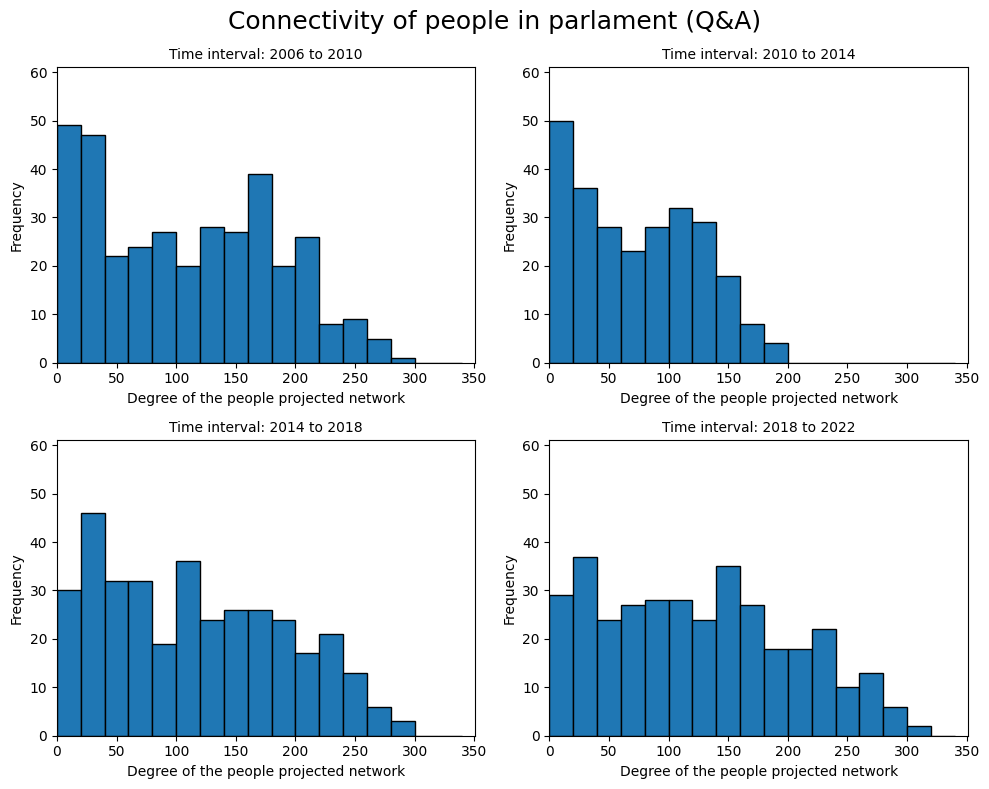

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

fig.suptitle("Connectivity of people in parlament (Q&A)", fontsize = 18)

for i, graph_people in enumerate(people_proj_e_qa_largest):
  degree_people = dict((graph_people).degree()).values()
  axs[i].set_xlabel("Degree of the people projected network")
  axs[i].set_xlim(0, 351)
  axs[i].set_xticks(range(0,351,50))
  axs[i].set_ylabel("Frequency")
  axs[i].set_ylim(0, 61)
  axs[i].set_title(f"Time interval: {election_interval_name[i]}", fontsize=10)
  axs[i].hist(degree_people, edgecolor="black", bins=range(0,351,20))

plt.tight_layout()
plt.show()

### Nr of topics of interesst

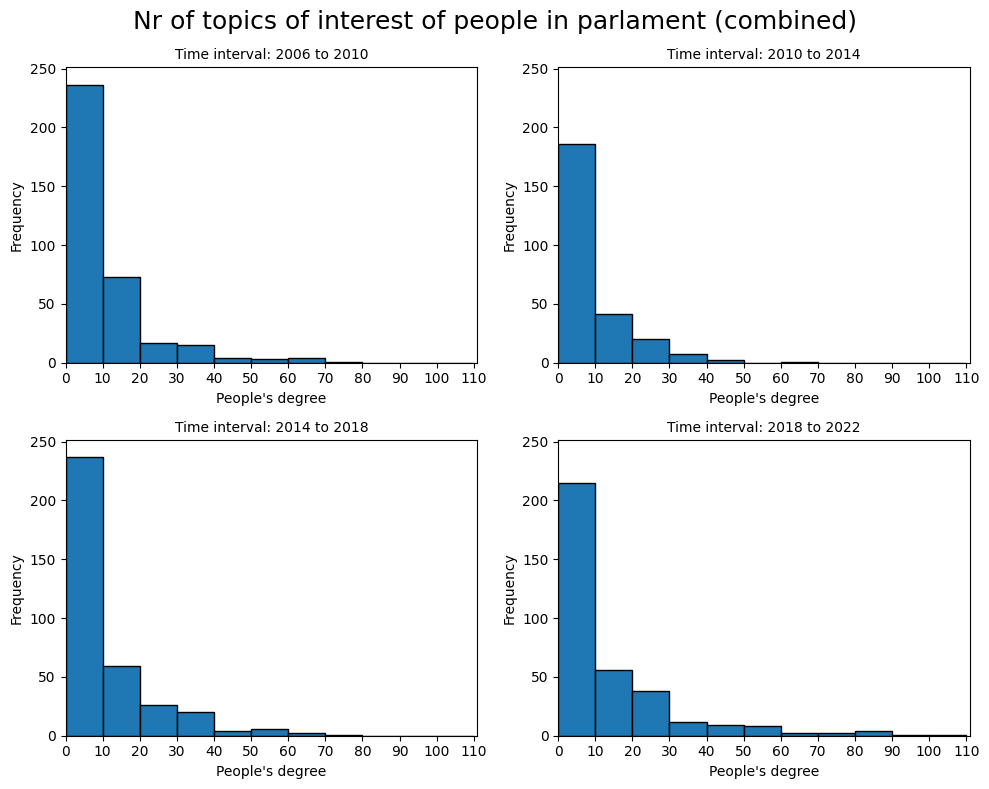

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

fig.suptitle("Nr of topics of interest of people in parlament (combined)", fontsize = 18)

for i, graph in enumerate(graphs_e_comb):
  people, topics = bipartite.sets(graph)
  degree_topics, degree_people = bipartite.degrees(graph, people)
  degree_people = dict(degree_people).values()
  axs[i].set_xlabel("People's degree")
  axs[i].set_xlim(0, 111)
  axs[i].set_xticks(range(0,111,10))
  axs[i].set_ylabel("Frequency")
  axs[i].set_ylim(0, 251)
  axs[i].set_title(f"Time interval: {election_interval_name[i]}", fontsize=10)
  axs[i].hist(degree_people, edgecolor="black", bins=range(0,111,10))

plt.tight_layout()
plt.show()

102
80
82
125


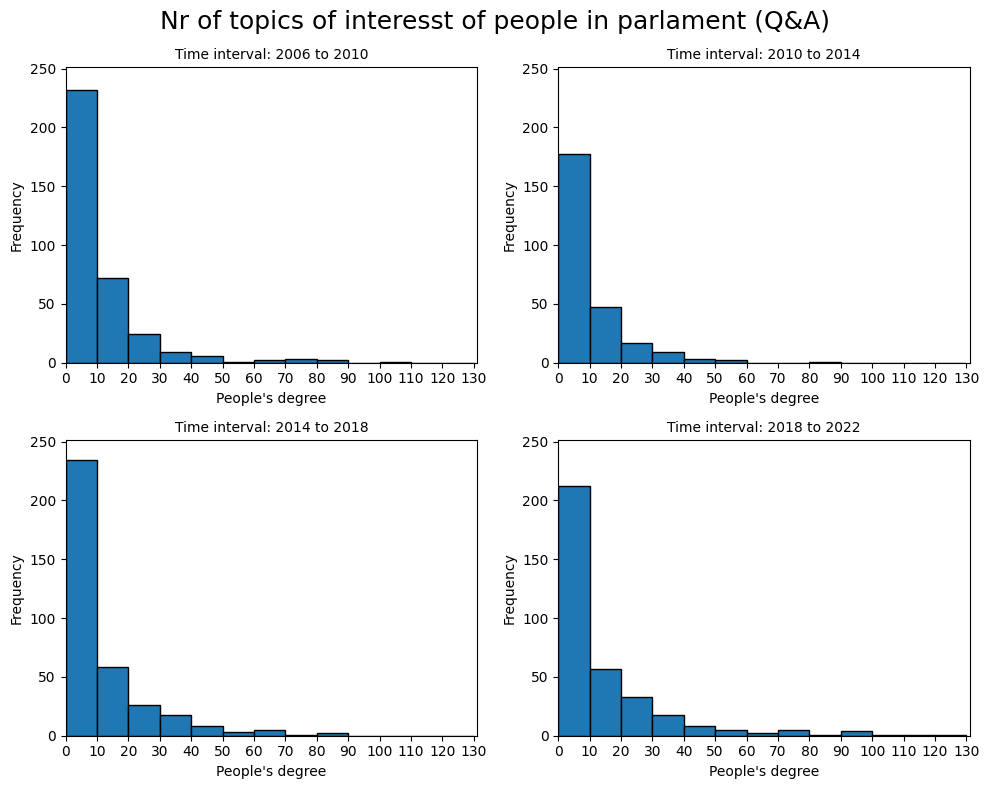

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

fig.suptitle("Nr of topics of interesst of people in parlament (Q&A)", fontsize = 18)

for i, graph in enumerate(graphs_e_qa_largest):
  people, topics = bipartite.sets(graph)
  #graph_people = bipartite.weighted_projected_graph(graph, people)
  degree_topics, degree_people = bipartite.degrees(graph, people)
  degree_people = dict(degree_people).values()
  print(max(degree_people))
  axs[i].set_xlabel("People's degree")
  axs[i].set_xlim(0, 131)
  axs[i].set_xticks(range(0,131,10))
  axs[i].set_ylabel("Frequency")
  axs[i].set_ylim(0, 251)
  axs[i].set_title(f"Time interval: {election_interval_name[i]}", fontsize=10)
  axs[i].hist(degree_people, edgecolor="black", bins=range(0,131,10))

plt.tight_layout()
plt.show()

## Nr of people per topic

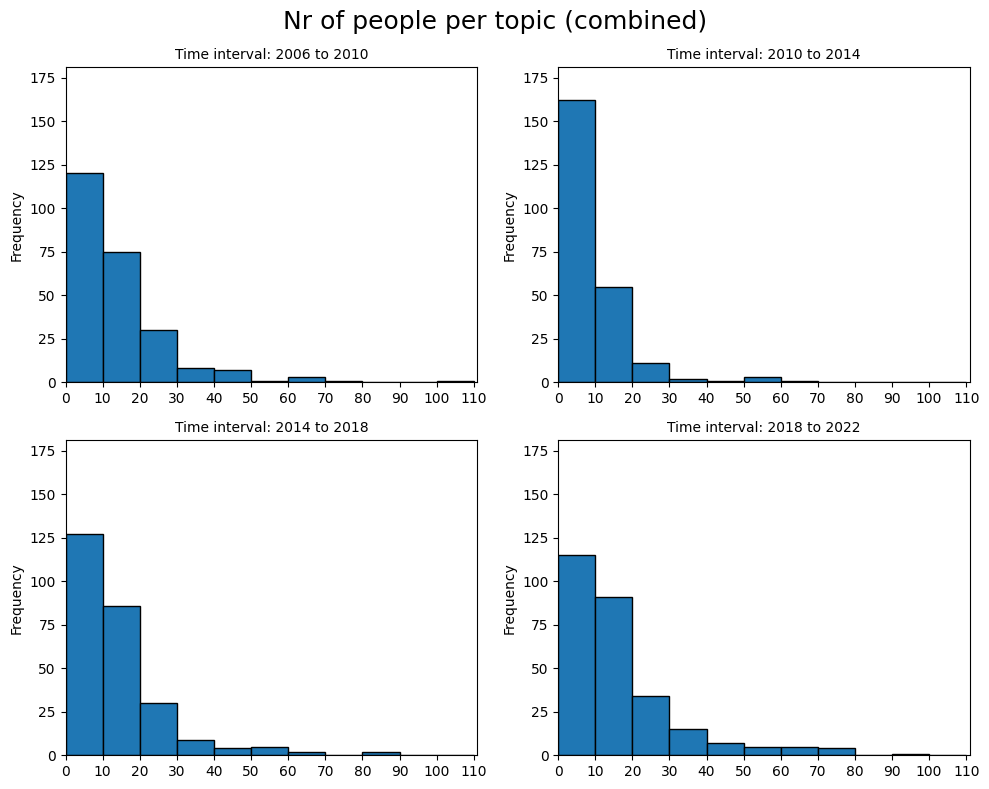

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

fig.suptitle("Nr of people per topic (combined)", fontsize = 18)

for i, graph in enumerate(graphs_e_comb):
  people, topics = bipartite.sets(graph)
  degree_topics, degree_people = bipartite.degrees(graph, people)
  degree_topics = dict(degree_topics).values()
  #print(max(degree_topics))
  axs[i].set_xlabel("")
  axs[i].set_xlim(0, 111)
  axs[i].set_xticks(range(0,111,10))
  axs[i].set_ylabel("Frequency")
  axs[i].set_ylim(0, 181)
  axs[i].set_title(f"Time interval: {election_interval_name[i]}", fontsize=10)
  axs[i].hist(degree_topics, edgecolor="black", bins=range(0,111,10))

plt.tight_layout()
plt.show()

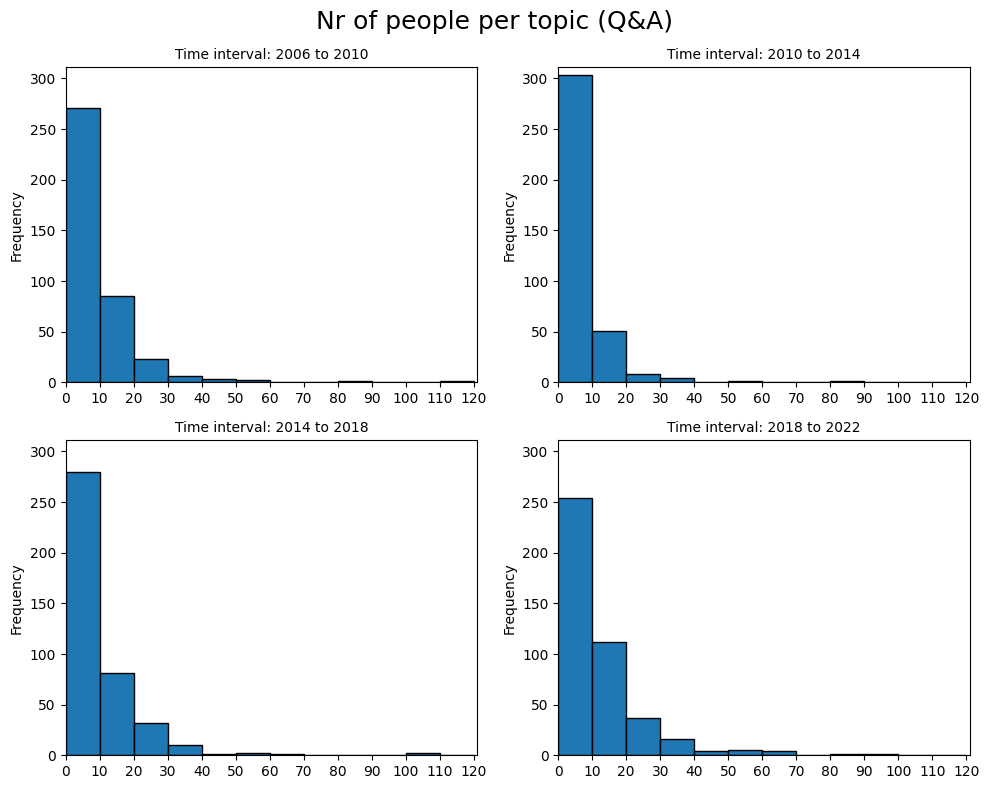

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

fig.suptitle("Nr of people per topic (Q&A)", fontsize = 18)

for i, graph in enumerate(graphs_e_qa_largest):
  people, topics = bipartite.sets(graph)
  degree_topics, degree_people = bipartite.degrees(graph, people)
  degree_topics = dict(degree_topics).values()
  axs[i].set_xlabel("")
  axs[i].set_xlim(0, 121)
  axs[i].set_xticks(range(0,121,10))
  axs[i].set_ylabel("Frequency")
  axs[i].set_ylim(0, 311)
  axs[i].set_title(f"Time interval: {election_interval_name[i]}", fontsize=10)
  axs[i].hist(degree_topics, edgecolor="black", bins=range(0,121,10))

plt.tight_layout()
plt.show()

## Average degree

In [62]:
# Divide the people in the graph based on their parties 
S_lst = []
V_lst = []
MP_lst = []
C_lst = []
L_lst = []
M_lst = []
KD_lst = []
SD_lst = []
no_party_lst = []

for i, graph in enumerate(graphs_e_comb):
  people, topics = bipartite.sets(graph)
  for person in people:
    if graph.nodes[person]['party'] == 'S':
      S_lst.append(person)
    if graph.nodes[person]['party'] == 'V':
      V_lst.append(person)
    if graph.nodes[person]['party'] == 'MP':
      MP_lst.append(person)
    if graph.nodes[person]['party'] == 'C':
      C_lst.append(person)
    if graph.nodes[person]['party'] == 'L':
      L_lst.append(person)
    if graph.nodes[person]['party'] == 'M':
      M_lst.append(person)
    if graph.nodes[person]['party'] == 'KD':
      KD_lst.append(person)
    if graph.nodes[person]['party'] == 'SD':
      SD_lst.append(person)
    if graph.nodes[person]['party'] == '-':
      no_party_lst.append(person)

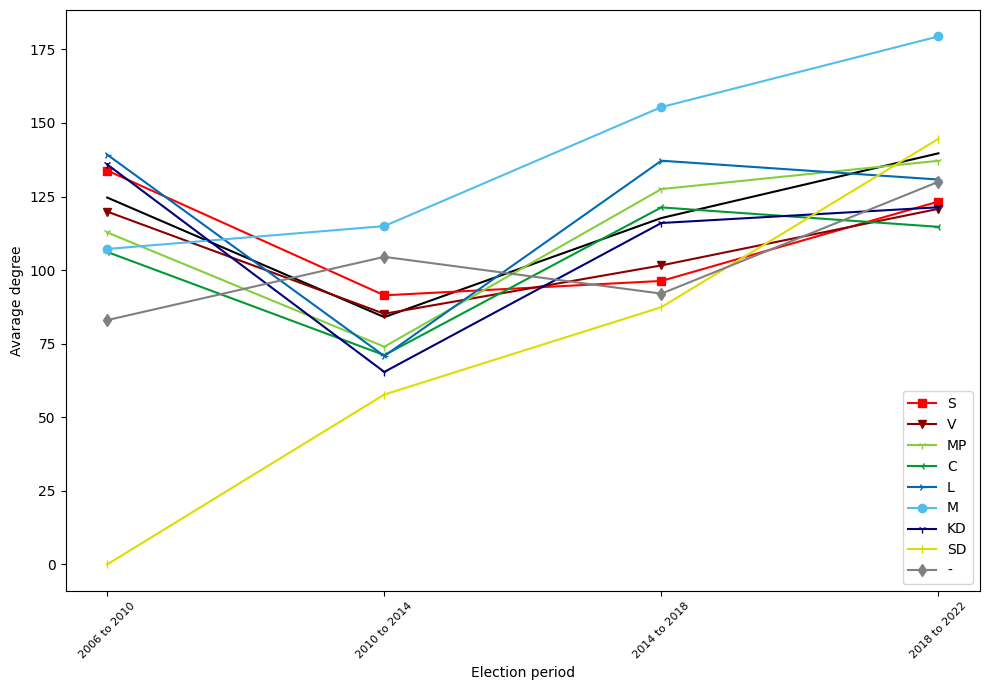

In [63]:

fig = plt.figure(figsize = (10, 7))

all = []
S_av_degree = []
V_av_degree = []
MP_av_degree = []
C_av_degree = []
L_av_degree = []
M_av_degree = []
KD_av_degree = []
SD_av_degree = []
no_party_av_degree = []


for i, graph in enumerate(graphs_e_comb):
  people, topics = bipartite.sets(graph)
  graph_people = bipartite.weighted_projected_graph(graph, people)
  degree_people = dict((graph_people).degree()).values()
  all.append(sum(degree_people)/float(len(degree_people)))

  if len(dict((graph_people).degree(S_lst)).values()) != 0:
    S_av_degree.append(sum(dict((graph_people).degree(S_lst)).values())/float(len(dict((graph_people).degree(S_lst)).values())))
  else:
    S_av_degree.append(0)
  if len(dict((graph_people).degree(V_lst)).values()) != 0:
    V_av_degree.append(sum(dict((graph_people).degree(V_lst)).values())/float(len(dict((graph_people).degree(V_lst)).values())))
  else:
    V_av_degree.append(0)
  if len(dict((graph_people).degree(MP_lst)).values()) != 0:
    MP_av_degree.append(sum(dict((graph_people).degree(MP_lst)).values())/float(len(dict((graph_people).degree(MP_lst)).values())))
  else:
    MP_av_degree.append(0)
  if len(dict((graph_people).degree(C_lst)).values()) != 0:
    C_av_degree.append(sum(dict((graph_people).degree(C_lst)).values())/float(len(dict((graph_people).degree(C_lst)).values())))
  else:
    C_av_degree.append(0)
  if len(dict((graph_people).degree(L_lst)).values()) != 0:
    L_av_degree.append(sum(dict((graph_people).degree(L_lst)).values())/float(len(dict((graph_people).degree(L_lst)).values())))
  else:
    L_av_degree.append(0)
  if len(dict((graph_people).degree(M_lst)).values()) != 0:
    M_av_degree.append(sum(dict((graph_people).degree(M_lst)).values())/float(len(dict((graph_people).degree(M_lst)).values())))
  else:
    M_av_degree.append(0)
  if len(dict((graph_people).degree(KD_lst)).values()) != 0:
    KD_av_degree.append(sum(dict((graph_people).degree(KD_lst)).values())/float(len(dict((graph_people).degree(KD_lst)).values())))
  else:
    KD_av_degree.append(0)
  if len(dict((graph_people).degree(SD_lst)).values()) != 0:
    SD_av_degree.append(sum(dict((graph_people).degree(SD_lst)).values())/float(len(dict((graph_people).degree(SD_lst)).values())))
  else:
    SD_av_degree.append(0)
  if len(dict((graph_people).degree(no_party_lst)).values()) != 0:
    no_party_av_degree.append(sum(dict((graph_people).degree(no_party_lst)).values())/float(len(dict((graph_people).degree(no_party_lst)).values())))
  else:
    no_party_av_degree.append(0)


x = range(0,len(graphs_e_comb))
plt.plot(x, all, color='black')
plt.plot(x, S_av_degree, marker='s', color="red", label="S") # color="#E8112d"
plt.plot(x, V_av_degree, marker='v', color="darkred", label="V") # color="#DA291C"
plt.plot(x, MP_av_degree, marker='1', color="#83CF39", label="MP")
plt.plot(x, C_av_degree,marker='3', color="#009933", label="C")
plt.plot(x, L_av_degree, marker='4', color="#006AB3", label="L")
plt.plot(x, M_av_degree, marker='o', color="#52BDEC", label="M")
plt.plot(x, KD_av_degree, marker='1', color="#000077", label="KD")
plt.plot(x, SD_av_degree, marker='|', color="#DDDD00", label="SD")
plt.plot(x, no_party_av_degree, marker='d', color="gray", label="-")


plt.xlabel("Election period")
#plt.xlim(0, 351)
#plt.xticks(range(0,351,50))
plt.xticks(x, election_interval_name, rotation=45, fontsize=8)
plt.ylabel("Avarage degree")
#plt.ylim(0, 61)

plt.legend()
plt.tight_layout()
plt.show()

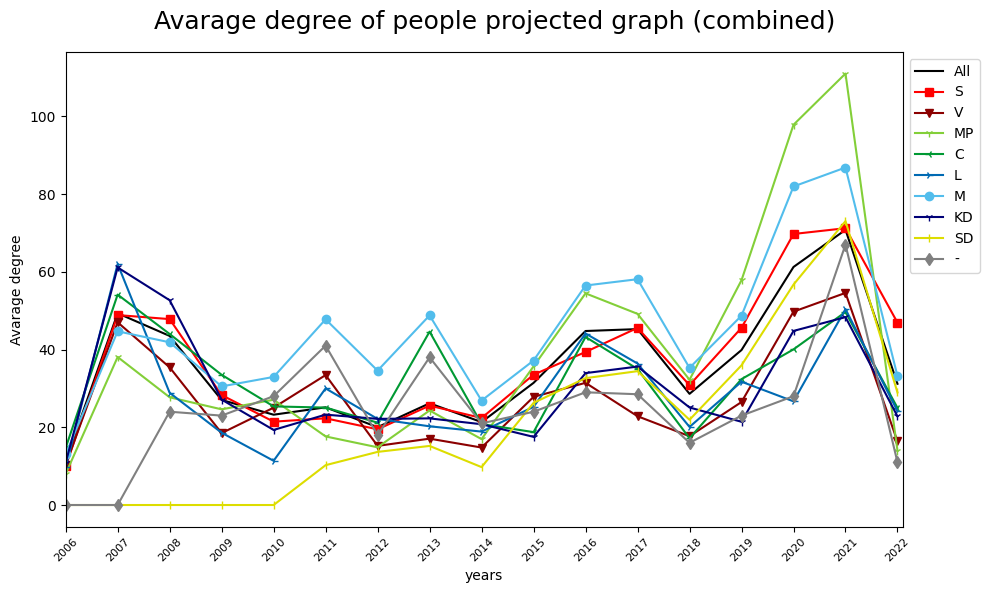

In [67]:
S_lst = []
V_lst = []
MP_lst = []
C_lst = []
L_lst = []
M_lst = []
KD_lst = []
SD_lst = []
no_party_lst = []

for i, graph in enumerate(graphs_year_comb):
  people, topics = bipartite.sets(graph)
  for person in people:
    if graph.nodes[person]['party'] == 'S':
      S_lst.append(person)
    if graph.nodes[person]['party'] == 'V':
      V_lst.append(person)
    if graph.nodes[person]['party'] == 'MP':
      MP_lst.append(person)
    if graph.nodes[person]['party'] == 'C':
      C_lst.append(person)
    if graph.nodes[person]['party'] == 'L':
      L_lst.append(person)
    if graph.nodes[person]['party'] == 'M':
      M_lst.append(person)
    if graph.nodes[person]['party'] == 'KD':
      KD_lst.append(person)
    if graph.nodes[person]['party'] == 'SD':
      SD_lst.append(person)
    if graph.nodes[person]['party'] == '-':
      no_party_lst.append(person)


fig, axs = plt.subplots(figsize=(10, 6))
fig.suptitle("Avarage degree of people projected graph (combined)", fontsize = 18)

all = []
S_av_degree = []
V_av_degree = []
MP_av_degree = []
C_av_degree = []
L_av_degree = []
M_av_degree = []
KD_av_degree = []
SD_av_degree = []
no_party_av_degree = []


for i, graph in enumerate(graphs_year_comb):
  people, topics = bipartite.sets(graph)
  graph_people = bipartite.weighted_projected_graph(graph, people)
  degree_people = dict((graph_people).degree()).values()
  all.append(sum(degree_people)/float(len(degree_people)))

  if len(dict((graph_people).degree(S_lst)).values()) != 0:
    S_av_degree.append(sum(dict((graph_people).degree(S_lst)).values())/float(len(dict((graph_people).degree(S_lst)).values())))
  else:
    S_av_degree.append(0)
  if len(dict((graph_people).degree(V_lst)).values()) != 0:
    V_av_degree.append(sum(dict((graph_people).degree(V_lst)).values())/float(len(dict((graph_people).degree(V_lst)).values())))
  else:
    V_av_degree.append(0)
  if len(dict((graph_people).degree(MP_lst)).values()) != 0:
    MP_av_degree.append(sum(dict((graph_people).degree(MP_lst)).values())/float(len(dict((graph_people).degree(MP_lst)).values())))
  else:
    MP_av_degree.append(0)
  if len(dict((graph_people).degree(C_lst)).values()) != 0:
    C_av_degree.append(sum(dict((graph_people).degree(C_lst)).values())/float(len(dict((graph_people).degree(C_lst)).values())))
  else:
    C_av_degree.append(0)
  if len(dict((graph_people).degree(L_lst)).values()) != 0:
    L_av_degree.append(sum(dict((graph_people).degree(L_lst)).values())/float(len(dict((graph_people).degree(L_lst)).values())))
  else:
    L_av_degree.append(0)
  if len(dict((graph_people).degree(M_lst)).values()) != 0:
    M_av_degree.append(sum(dict((graph_people).degree(M_lst)).values())/float(len(dict((graph_people).degree(M_lst)).values())))
  else:
    M_av_degree.append(0)
  if len(dict((graph_people).degree(KD_lst)).values()) != 0:
    KD_av_degree.append(sum(dict((graph_people).degree(KD_lst)).values())/float(len(dict((graph_people).degree(KD_lst)).values())))
  else:
    KD_av_degree.append(0)
  if len(dict((graph_people).degree(SD_lst)).values()) != 0:
    SD_av_degree.append(sum(dict((graph_people).degree(SD_lst)).values())/float(len(dict((graph_people).degree(SD_lst)).values())))
  else:
    SD_av_degree.append(0)
  if len(dict((graph_people).degree(no_party_lst)).values()) != 0:
    no_party_av_degree.append(sum(dict((graph_people).degree(no_party_lst)).values())/float(len(dict((graph_people).degree(no_party_lst)).values())))
  else:
    no_party_av_degree.append(0)


x = range(0,len(graphs_year_comb))
plt.plot(x, all, color='black',  label="All")
plt.plot(x, S_av_degree, marker='s', color="red", label="S") # color="#E8112d"
plt.plot(x, V_av_degree, marker='v', color="darkred", label="V") # color="#DA291C"
plt.plot(x, MP_av_degree, marker='1', color="#83CF39", label="MP")
plt.plot(x, C_av_degree,marker='3', color="#009933", label="C")
plt.plot(x, L_av_degree, marker='4', color="#006AB3", label="L")
plt.plot(x, M_av_degree, marker='o', color="#52BDEC", label="M")
plt.plot(x, KD_av_degree, marker='1', color="#000077", label="KD")
plt.plot(x, SD_av_degree, marker='|', color="#DDDD00", label="SD")
plt.plot(x, no_party_av_degree, marker='d', color="gray", label="-")


intervals = [(0, 8.7), (8.7, 13.1), (13.1, 15.5), (15.5, 15.9), (15.9, 16.7)]
government = ["Reinfeldt, M+FP+C+KD","Löfven I, S+MP", "Löfven II, S+MP", "Löfven III, S+MP", "Andersson, S"]


plt.xlabel("years")
plt.xticks(x, years, rotation=45, fontsize=8)
plt.ylabel("Avarage degree")
plt.xlim(0, 16.1)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

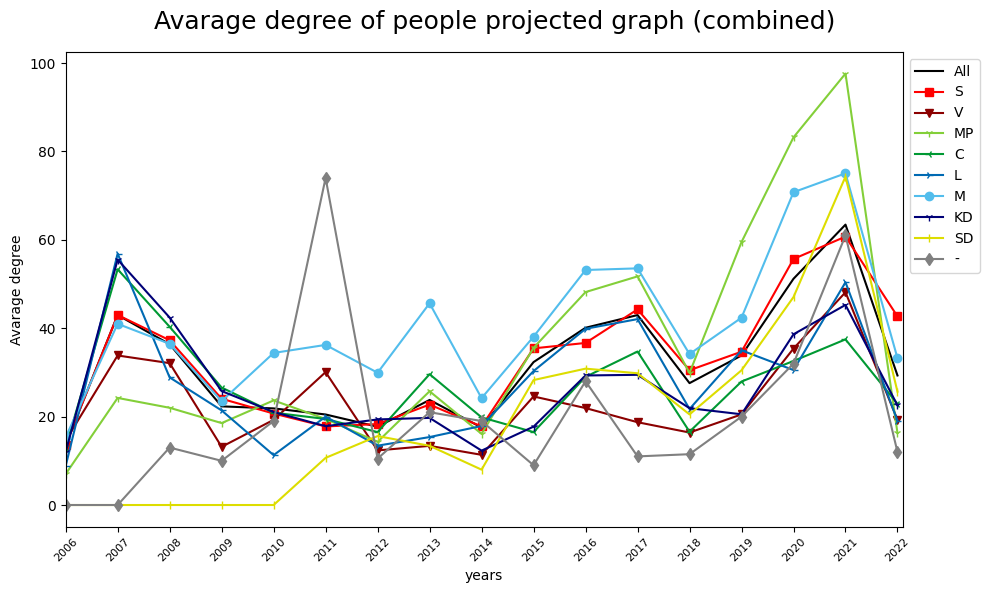

In [71]:
S_lst = []
V_lst = []
MP_lst = []
C_lst = []
L_lst = []
M_lst = []
KD_lst = []
SD_lst = []
no_party_lst = []

for i, graph in enumerate(graphs_year_qa_largest):
  people, topics = bipartite.sets(graph)
  for person in people:
    if graph.nodes[person]['party'] == 'S':
      S_lst.append(person)
    if graph.nodes[person]['party'] == 'V':
      V_lst.append(person)
    if graph.nodes[person]['party'] == 'MP':
      MP_lst.append(person)
    if graph.nodes[person]['party'] == 'C':
      C_lst.append(person)
    if graph.nodes[person]['party'] == 'L':
      L_lst.append(person)
    if graph.nodes[person]['party'] == 'M':
      M_lst.append(person)
    if graph.nodes[person]['party'] == 'KD':
      KD_lst.append(person)
    if graph.nodes[person]['party'] == 'SD':
      SD_lst.append(person)
    if graph.nodes[person]['party'] == '-':
      no_party_lst.append(person)


fig, axs = plt.subplots(figsize=(10, 6))
fig.suptitle("Avarage degree of people projected graph (combined)", fontsize = 18)
all = []
S_av_degree = []
V_av_degree = []
MP_av_degree = []
C_av_degree = []
L_av_degree = []
M_av_degree = []
KD_av_degree = []
SD_av_degree = []
no_party_av_degree = []


for i, graph in enumerate(graphs_year_qa_largest):
  people, topics = bipartite.sets(graph)
  graph_people = bipartite.weighted_projected_graph(graph, people)
  degree_people = dict((graph_people).degree()).values()
  all.append(sum(degree_people)/float(len(degree_people)))

  if len(dict((graph_people).degree(S_lst)).values()) != 0:
    S_av_degree.append(sum(dict((graph_people).degree(S_lst)).values())/float(len(dict((graph_people).degree(S_lst)).values())))
  else:
    S_av_degree.append(0)
  if len(dict((graph_people).degree(V_lst)).values()) != 0:
    V_av_degree.append(sum(dict((graph_people).degree(V_lst)).values())/float(len(dict((graph_people).degree(V_lst)).values())))
  else:
    V_av_degree.append(0)
  if len(dict((graph_people).degree(MP_lst)).values()) != 0:
    MP_av_degree.append(sum(dict((graph_people).degree(MP_lst)).values())/float(len(dict((graph_people).degree(MP_lst)).values())))
  else:
    MP_av_degree.append(0)
  if len(dict((graph_people).degree(C_lst)).values()) != 0:
    C_av_degree.append(sum(dict((graph_people).degree(C_lst)).values())/float(len(dict((graph_people).degree(C_lst)).values())))
  else:
    C_av_degree.append(0)
  if len(dict((graph_people).degree(L_lst)).values()) != 0:
    L_av_degree.append(sum(dict((graph_people).degree(L_lst)).values())/float(len(dict((graph_people).degree(L_lst)).values())))
  else:
    L_av_degree.append(0)
  if len(dict((graph_people).degree(M_lst)).values()) != 0:
    M_av_degree.append(sum(dict((graph_people).degree(M_lst)).values())/float(len(dict((graph_people).degree(M_lst)).values())))
  else:
    M_av_degree.append(0)
  if len(dict((graph_people).degree(KD_lst)).values()) != 0:
    KD_av_degree.append(sum(dict((graph_people).degree(KD_lst)).values())/float(len(dict((graph_people).degree(KD_lst)).values())))
  else:
    KD_av_degree.append(0)
  if len(dict((graph_people).degree(SD_lst)).values()) != 0:
    SD_av_degree.append(sum(dict((graph_people).degree(SD_lst)).values())/float(len(dict((graph_people).degree(SD_lst)).values())))
  else:
    SD_av_degree.append(0)
  if len(dict((graph_people).degree(no_party_lst)).values()) != 0:
    no_party_av_degree.append(sum(dict((graph_people).degree(no_party_lst)).values())/float(len(dict((graph_people).degree(no_party_lst)).values())))
  else:
    no_party_av_degree.append(0)


x = range(0,len(graphs_year_comb))
plt.plot(x, all, color='black', label="All")
plt.plot(x, S_av_degree, marker='s', color="red", label="S") # color="#E8112d"
plt.plot(x, V_av_degree, marker='v', color="darkred", label="V") # color="#DA291C"
plt.plot(x, MP_av_degree, marker='1', color="#83CF39", label="MP")
plt.plot(x, C_av_degree,marker='3', color="#009933", label="C")
plt.plot(x, L_av_degree, marker='4', color="#006AB3", label="L")
plt.plot(x, M_av_degree, marker='o', color="#52BDEC", label="M")
plt.plot(x, KD_av_degree, marker='1', color="#000077", label="KD")
plt.plot(x, SD_av_degree, marker='|', color="#DDDD00", label="SD")
plt.plot(x, no_party_av_degree, marker='d', color="gray", label="-")



plt.xlabel("years")
plt.xticks(x, years, rotation=45, fontsize=8)
plt.ylabel("Avarage degree")
plt.xlim(0, 16.1)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()